 January 16, 2023


# Social Data Science Base Camp Exam 
____

In this project, I will extract and analyse data on UFC fighters. It is not that I am particularly invested in the sport, however, I watch it often as my boyfriend enjoys it. As he was investigating the UFC website and reading the stats on each fighters' performance, I found the website to be interesting and that it contained links to the fighters' social media platforms. 


To meet the exam requirements and to make this notebook more manageable, the structure is as follows:

**The notebook is divided into five overall sections**: 
1. Scraping the UFC website from data 
2. Getting Twitter information 
3. Merging datasets 
    * ethical considerations for collecting the data  
4. Data visualization 
5. Data analysis 
    * linear regression
    * Linear regression with non-binary categorical variable 
    * Logistic regression 
    * Logistic regression with interaction term
    * squared or log
    


Below, I will start with the first section. 

## Section 1: Scraping the UFC website 

For this task, I will scrape data from UFC's official website. The website lists all fighters in the UFC and contains information on each fighter, statistics on their performance (e.g. wins by knockout), as well as background information (e.g., age) and links to their social media websites. 
I have filtered the fighters based on fighting style, where those included operates within MMA, jiu-jitsu and Brazilian jiu-jitsu (picked randomly to get a fighter count of around 300). 

I begin this section by scraping the data from 336 fighters. 
Due to empty boxes within the HTML table and/or advertisement, I removed these and ended with 265 fighters. 
From each table, I use the Ufc HTML link to get more information on each fighter by extracting data from each fighter's profile. Here I get information such as age, wins by knockout, wins by submission, significant strikes landed per minute, arm reach, etc. I find these variables interesting to investigate for the analysis, as I believe they might answer questions such as whether there is a relationship between reach (a.k.a., sports language for the length of the arm) and wins by knockout — or similar relationships. 

At the end of section 1, I collect the different information in a data frame and save this to a CSV file. 

Let's start:



In [4]:
# importing requests and getting the HTML code

import requests as rq
ufc = rq.get('https://www.ufc.com/athletes/all?filters%5B0%5D=fighting_style%3A7146')

# checking if status code 200, ensuring that everyting is fine.
ufc.status_code

200

In [5]:
from bs4 import BeautifulSoup

In [18]:
# turning it into a beautiful soup object

from bs4 import BeautifulSoup
ufc_soup = BeautifulSoup(ufc.text) #text is basically the html code
ufc_soup

<!DOCTYPE html>
<html dir="ltr" lang="en" prefix="og: https://ogp.me/ns#">
<head>
<meta charset="utf-8"/><script type="text/javascript">(window.NREUM||(NREUM={})).init={ajax:{deny_list:["bam.nr-data.net"]}};(window.NREUM||(NREUM={})).loader_config={licenseKey:"3cad7d7fc7",applicationID:"190390077"};/*! For license information please see nr-loader-rum-1220.min.js.LICENSE.txt */
!function(t,e){"object"==typeof exports&&"object"==typeof module?module.exports=e():"function"==typeof define&&define.amd?define([],e):"object"==typeof exports?exports.NRBA=e():t.NRBA=e()}(self,(function(){return function(){var t,e,n={9034:function(t,e,n){"use strict";var r=n(4168);e.Z=(0,r.ky)(16)},5973:function(t,e,n){"use strict";n.d(e,{I:function(){return r}});var r=0,o=navigator.userAgent.match(/Firefox[\/\s](\d+\.\d+)/);o&&(r=+o[1])},4280:function(t,e,n){"use strict";n.d(e,{H:function(){return o}});var r=document.createElement("div");r.innerHTML="\x3c!--[if lte IE 6]><div></div><![endif]--\x3e\x3c!--[if lte

I see that the webpage is structured so that all the fighters are within a table. 
Thus, I limit the soup only to the information within this table and store them in an object.



In [19]:
fighter = ufc_soup.find_all('li', class_ = "l-flex__item")

In [38]:
# lets take a look
fighter

[<li class="l-flex__item">
 <div class="node node--type-athlete node--view-mode-all-athletes-result ds-1col clearfix">
 <div class="c-listing-athlete-flipcard white">
 <div class="c-listing-athlete-flipcard__inner">
 <div class="c-listing-athlete-flipcard__front">
 <div class="c-listing-athlete__thumbnail">
 <div class="field field--name-image field--type-entity-reference field--label-hidden field__item"> <div class="layout layout--onecol">
 <div class="layout__region layout__region--content">
 <img class="image-style-teaser" height="300" loading="lazy" src="https://dmxg5wxfqgb4u.cloudfront.net/styles/teaser/s3/image/ufc-fighter-container/69687/profile-galery/profile-picture/ADAMS_JUAN.png?VersionId=AYQNszHv_M6up4fZKYRgVgoOYDhW.ZbE&amp;itok=NUx3BidF" width="400"/>
 </div>
 </div>
 </div>
 </div>
 <div class="c-listing-athlete__text">
 <span class="c-listing-athlete__nickname">
 <div class="field field--name-nickname field--type-string field--label-hidden">
 <div class="field__item">"Th

The page I am trying to scrape has a "load more" button. As a result, my code from above only provided 12 fighters (as are presented on the first page on the website). 

In [20]:
len(fighter)

12

To scrape information from the other fighters, I will use selenium.

In [3]:
# installing selenium
import selenium

In [15]:
# importing webdrive:

import webdriver_manager

In [24]:
#Furthermore, there are several packages I need for making this work.

import webdriver_manager
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time

# the given URL to the ufc webpage:
UFC_URL = "https://www.ufc.com/athletes/all?filters%5B0%5D=fighting_style%3A7145&filters%5B1%5D=fighting_style%3A7146&filters%5B2%5D=fighting_style%3A7150"

PATIENCE_TIME = 60

LOAD_MORE_BUTTON_XPATH = "//a[@class='button']" # the xpath for the load more button. I found this 
                                                # when I inspected the element. From here, I could 
                                                # simply copy the xpath from the inspect

driver = webdriver.Chrome(ChromeDriverManager().install()) # This code below installs the webdriver. 
                                #I have chosen chrome for convenience purposes as this was already 
                                # installed on my computer. When running this code, it opens a new chrome window. 
driver.get(UFC_URL)

# There is probably a more elegant way of doing this, but this is how I did: 
# To reach the final page, I'd have to click the "load more" button 27 times:

for n in range(27):
    try:
        loadMoreButton = driver.find_element(By.XPATH, LOAD_MORE_BUTTON_XPATH)
        time.sleep(2)
        loadMoreButton.click()
        time.sleep(5) 
    except:
        pass
print("Complete")
time.sleep(10)


page = driver.page_source # now I got the page in the page element

soup = BeautifulSoup(page, "html.parser") #making the page into a soup object

[WDM] - Downloading: 100%|█████████████████| 8.61M/8.61M [00:01<00:00, 5.17MB/s]
/var/folders/l0/m8zxvy4x0js55dkgfb0dh8hh0000gn/T/ipykernel_1334/2433229792.py:16: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) # This code below installs the webdriver.


Complete


In [26]:
# Investigating it
soup

<html class="js" dir="ltr" lang="en" prefix="og: https://ogp.me/ns#"><head><script src="https://bam.nr-data.net/1/3cad7d7fc7?a=190390077&amp;v=1220.PROD&amp;to=NgZVbUYDCEdSVEdeWA9MdExHFglZHFtDDVYVC1tcQAcV&amp;rst=20588&amp;ck=0&amp;s=95038b0d42f45fa3&amp;ref=https://www.ufc.com/athletes/all&amp;ap=691&amp;be=1754&amp;fe=16525&amp;dc=5630&amp;perf=%7B%22timing%22:%7B%22of%22:1672838151219,%22n%22:0,%22f%22:11,%22dn%22:36,%22dne%22:127,%22c%22:127,%22s%22:182,%22ce%22:273,%22rq%22:285,%22rp%22:1165,%22rpe%22:1195,%22dl%22:1300,%22di%22:7382,%22ds%22:7383,%22de%22:7472,%22dc%22:18278,%22l%22:18279,%22le%22:18305%7D,%22navigation%22:%7B%7D%7D&amp;fp=4844&amp;fcp=4849&amp;at=GkFCGw4ZGxgRVhENTBwe&amp;jsonp=NREUM.setToken" type="text/javascript"></script><script async="" src="https://www.google-analytics.com/analytics.js" type="text/javascript"></script><script async="" src="https://analytics.tiktok.com/i18n/pixel/config.js?sdkid=BTI5HJHSNNBBOAK2D9UG&amp;hostname=www.ufc.com" type="text/javas

In [27]:
# as above, I extract the table I want from the soup and see how many fighters we have now 
# - luckily, a bit more than 12 this time.

fighter_soup = soup.find_all('li', class_ = "l-flex__item")
print(len(fighter_soup))

336


In [29]:
# inspecting one 

fighter_soup[0]

<li class="l-flex__item">
<div class="node node--type-athlete node--view-mode-all-athletes-result ds-1col clearfix">
<div class="c-listing-athlete-flipcard white">
<div class="c-listing-athlete-flipcard__inner">
<div class="c-listing-athlete-flipcard__front">
<div class="c-listing-athlete__thumbnail">
<div class="field field--name-image field--type-entity-reference field--label-hidden field__item"> <div class="layout layout--onecol">
<div class="layout__region layout__region--content">
<img class="image-style-teaser" height="300" loading="lazy" src="https://dmxg5wxfqgb4u.cloudfront.net/styles/teaser/s3/image/ufc-fighter-container/69687/profile-galery/profile-picture/ADAMS_JUAN.png?VersionId=AYQNszHv_M6up4fZKYRgVgoOYDhW.ZbE&amp;itok=NUx3BidF" width="400"/>
</div>
</div>
</div>
</div>
<div class="c-listing-athlete__text">
<span class="c-listing-athlete__nickname">
<div class="field field--name-nickname field--type-string field--label-hidden">
<div class="field__item">"The Kraken"</div>
<

In [32]:
# extracting the name 

fighter_soup[1].find('span', class_='c-listing-athlete__name').text #get the name

'\n          Juan Adams\n        '

In [95]:
# extracting the nickname 

fighter_soup[1].findAll('div', class_='field__item')[1].text

'"The Kraken"'

In [96]:
# extracting the weight class

fighter_soup[1].findAll('div', class_='field__item')[2].text

'Heavyweight'

In [97]:
# extracting the twitter

fighter_soup[1].findAll('a', class_='c-listing-athlete-flipcard__social-link')[0].get('href')

'https://twitter.com/chosenjuan285'

In [33]:
# extracting the profile link + adding the first part of the link to the string as this is not included in the html code

ufclink = "https://www.ufc.com"
ufclink + str(fighter_soup[1].find('a')['href'])

'https://www.ufc.com/athlete/juan-adams'

In [34]:
# Creating a function so that I can get all the information for each fighter at once

def extract_fighter_info(soup): 

    name = soup.find('span', class_='c-listing-athlete__name').text
    if 'weight' in soup.find_all('div', class_='field__item')[1].text:
        nickname = np.nan 
    else:
        nickname = soup.find_all('div', class_='field__item')[1].text
    
    if ' \n\n\n\n\n' in soup.find_all('div', class_='field__item')[2].text:
        weight_class = soup.find_all('div', class_='field__item')[1].text
    else: 
        weight_class = soup.find_all('div', class_='field__item')[2].text
    
    twitter_str = "twitter"
    
    twitter_final = []
    

    for i in [0,1,2]:
        try:
            link_temp0 = soup.find_all('a', class_='c-listing-athlete-flipcard__social-link')[0].get('href')
            link_temp1 = soup.find_all('a', class_='c-listing-athlete-flipcard__social-link')[1].get('href')
            link_temp2 = soup.find_all('a', class_='c-listing-athlete-flipcard__social-link')[2].get('href')
        except:
            pass
    
    if twitter_str in link_temp0: 
        twitter_final.append(link_temp0)
    elif twitter_str in link_temp1:
        twitter_final.append(link_temp1)
    elif twitter_str in link_temp1: 
        twitter_final.append(link_temp2)
    else: 
        twitter_final.append(np.nan)
        
        
    profil_link = ufclink + str(soup.find('a')['href'])

    return name, nickname, weight_class, twitter_final, profil_link


The function contains several loops. This is because I later encountered that not all fighters had nicknames. As a result, instead of being field_item[2] the weightclass took the place of the nickname and became field_item[1]. Hence, when I created the dataframe, the values for some of the fighters did not match the columns. Furthermore, the order of the twitter links was not consistent for all fighters. I consequently had to make a loop through the information within c-listing-athlete-flipcard__social-link' and then only use the info if the string contained twitter. 

In [67]:
# testing if it works - luckily it does.
extract_fighter_info(fighter_soup[1])

('\n          Juan Adams\n        ',
 '"The Kraken"',
 'Heavyweight',
 ['https://twitter.com/chosenjuan285'],
 'https://www.ufc.com/athlete/juan-adams')

Getting this information for all the fighters by iterating through the fighter_soup, using the function:

In [165]:
import pandas as pd

info = []
for i in range(len(fighter_soup)):
    try:
        temp = extract_fighter_info(fighter_soup[i])
    except: 
        temp = pd.NA
    info.append(temp)

In [166]:
# everything should now be stored in "Info"

info

[<NA>,
 ('\n          Juan Adams\n        ',
  '"The Kraken"',
  'Heavyweight',
  ['https://twitter.com/chosenjuan285'],
  'https://www.ufc.com/athlete/juan-adams'),
 ('\n          Zarrukh Adashev\n        ',
  '"The Lion"',
  'Flyweight',
  ['https://twitter.com/ZAdashev'],
  'https://www.ufc.com/athlete/zarrukh-adashev'),
 ('\n          Kevin Aguilar\n        ',
  '"Angel of Death"',
  'Featherweight',
  ['https://twitter.com/KevinAguilarAOD'],
  'https://www.ufc.com/athlete/kevin-aguilar'),
 ('\n          Amir Albazi\n        ',
  '"The Prince"',
  'Flyweight',
  ['https://twitter.com/AmirAlbazi'],
  'https://www.ufc.com/athlete/amir-albazi'),
 ('\n          José Aldo\n        ',
  nan,
  'Bantamweight',
  ['https://twitter.com/josealdojunior'],
  'https://www.ufc.com/athlete/jose-aldo'),
 ('\n          Bill Algeo\n        ',
  '"Senor Perfecto"',
  'Featherweight',
  ['https://twitter.com/ElSenorPerfecto'],
  'https://www.ufc.com/athlete/bill-algeo'),
 ('\n          Brendan Allen\n

In [167]:
# the first one is an NA which makes it difficult to execute the code below when we want 
# the list in a dataframe. I remove the first NA only. 

info.pop(0)

<NA>

In [168]:
# double checking that all fighters still are with us

len(info)

335

In [169]:
# making the info to dataframe

ufc_df = pd.DataFrame(info)

In [170]:
ufc_df

0                       1  \
0            \n          Juan Adams\n                    "The Kraken"   
1       \n          Zarrukh Adashev\n                      "The Lion"   
2         \n          Kevin Aguilar\n                "Angel of Death"   
3           \n          Amir Albazi\n                    "The Prince"   
4             \n          José Aldo\n                             NaN   
..                                        ...                     ...   
330  \n          Armando Villarreal\n                     "La Lumbre"   
331    \n          Cheyanne Vlismas\n          "The Warrior Princess"   
332    \n          Alexander Volkov\n                         "Drago"   
333       \n          Johnny Walker\n                             NaN   
334                                      <NA>                    None   

                       2                                      3  \
0            Heavyweight    [https://twitter.com/chosenjuan285]   
1              Flyweight         [https://twitter.com/ZAdashev]   
2          Featherweight  [https://twitter.com/KevinAguilarAOD]   
3              Flyweight       [https://twitter.com/AmirAlbazi]   
4           Bantamweight   [https://twitter.com/josealdojunior]   
..                   ...                                    ...   
330         Bantamweight      [https://twitter.com/LaLumbreBJJ]   
331  Women's Strawweight  [https://twitter.com/CheyWarPrincess]   
332          Heavyweight  [https://twitter.com/AlexDragoVolkov]   
333    Light Heavyweight     [https://twitter.com/JohnnyWalker]   
334                 None                                   None   

                                                  4  
0            https://www.ufc.com/athlete/juan-adams  
1       https://www.ufc.com/athlete/zarrukh-adashev  
2         https://www.ufc.com/athlete/kevin-aguilar  
3           https://www.ufc.com/athlete/amir-albazi  
4             https://www.ufc.com/athlete/jose-aldo  
..                                              ...  
330  https://www.ufc.com/athlete/armando-villarreal  
331    https://www.ufc.com/athlete/cheyanne-vlismas  
332    https://www.ufc.com/athlete/alexander-volkov  
333       https://www.ufc.com/athlete/johnny-walker  
334                                            None  

[335 rows x 5 columns]

In [171]:
# there are, however, extra whitespace and newline characters at the names. Cleaning it:
info1 = []

for inf in info: 
    try:
        temp = inf[0].strip()
    except TypeError: 
        temp= pd.NA
    info1.append(temp)

In [172]:
len(info1)

335

In [173]:
# changing the column 0 to the info1 list with cleaned names
ufc_df[0]=info1

In [174]:
ufc_df

0                       1                    2  \
0            Juan Adams            "The Kraken"          Heavyweight   
1       Zarrukh Adashev              "The Lion"            Flyweight   
2         Kevin Aguilar        "Angel of Death"        Featherweight   
3           Amir Albazi            "The Prince"            Flyweight   
4             José Aldo                     NaN         Bantamweight   
..                  ...                     ...                  ...   
330  Armando Villarreal             "La Lumbre"         Bantamweight   
331    Cheyanne Vlismas  "The Warrior Princess"  Women's Strawweight   
332    Alexander Volkov                 "Drago"          Heavyweight   
333       Johnny Walker                     NaN    Light Heavyweight   
334                <NA>                    None                 None   

                                         3  \
0      [https://twitter.com/chosenjuan285]   
1           [https://twitter.com/ZAdashev]   
2    [https://twitter.com/KevinAguilarAOD]   
3         [https://twitter.com/AmirAlbazi]   
4     [https://twitter.com/josealdojunior]   
..                                     ...   
330      [https://twitter.com/LaLumbreBJJ]   
331  [https://twitter.com/CheyWarPrincess]   
332  [https://twitter.com/AlexDragoVolkov]   
333     [https://twitter.com/JohnnyWalker]   
334                                   None   

                                                  4  
0            https://www.ufc.com/athlete/juan-adams  
1       https://www.ufc.com/athlete/zarrukh-adashev  
2         https://www.ufc.com/athlete/kevin-aguilar  
3           https://www.ufc.com/athlete/amir-albazi  
4             https://www.ufc.com/athlete/jose-aldo  
..                                              ...  
330  https://www.ufc.com/athlete/armando-villarreal  
331    https://www.ufc.com/athlete/cheyanne-vlismas  
332    https://www.ufc.com/athlete/alexander-volkov  
333       https://www.ufc.com/athlete/johnny-walker  
334                                            None  

[335 rows x 5 columns]

In [175]:
# Lets drop the rows that have all NAN values.
# The reason why some rows have all NA values is that some of the boxes of the structured HTML table 
# contain no fighter, but instead just an emty space or an advertisement. 

import numpy as np

ufc_df = ufc_df.dropna(how='all')
ufc_df.head(50)

0                        1                      2  \
0            Juan Adams             "The Kraken"            Heavyweight   
1       Zarrukh Adashev               "The Lion"              Flyweight   
2         Kevin Aguilar         "Angel of Death"          Featherweight   
3           Amir Albazi             "The Prince"              Flyweight   
4             José Aldo                      NaN           Bantamweight   
5            Bill Algeo         "Senor Perfecto"          Featherweight   
6         Brendan Allen                 "All In"           Middleweight   
7          Arnold Allen               "Almighty"          Featherweight   
8          Rafael Alves               "The Turn"            Lightweight   
9             Sam Alvey                "Smile'N"           Middleweight   
11       Alen Amedovski                      NaN           Middleweight   
12          Eryk Anders                 "Ya Boi"           Middleweight   
13       Megan Anderson                      NaN  Women's Featherweight   
14     Magomed Ankalaev                      NaN      Light Heavyweight   
15       Viviane Araújo                   "Vivi"      Women's Flyweight   
16       Daniel Argueta         "The Determined"          Featherweight   
17          Askar Askar                      NaN                "AK-47"   
18           Ben Askren                  "Funky"           Welterweight   
19     Raphael Assunção                      NaN           Bantamweight   
21         Miguel Baeza        "Caramel Thunder"           Welterweight   
23  Melsik Baghdasaryan                      NaN          Featherweight   
24       Raoni Barcelos                      NaN           Bantamweight   
25       Javid Basharat       "The Snow Leopard"           Bantamweight   
27     Joseph Benavidez                      NaN              Flyweight   
29       Jan Błachowicz                      NaN      Light Heavyweight   
30     Erin Blanchfield           "Cold Blooded"      Women's Flyweight   
31       Curtis Blaydes                  "Razor"            Heavyweight   
33     Rogerio Bontorin                      NaN              Flyweight   
35             Ray Borg   "The Tazmexican Devil"           Bantamweight   
36        Caio Borralho            "The Natural"           Middleweight   
37      Poliana Botelho                      NaN      Women's Flyweight   
38           Sean Brady                      NaN           Welterweight   
39       Ramiz Brahimaj                      NaN           Welterweight   
41         Martin Buday                  "Badys"            Heavyweight   
42         Shane Burgos              "Hurricane"          Featherweight   
43        Herbert Burns              "The Blaze"          Featherweight   
44        Gilbert Burns                "Durinho"           Welterweight   
46        Vince Cachero            "The Anomaly"           Bantamweight   
47         Aleksa Camur                      NaN      Light Heavyweight   
48        Cortney Casey              "Cast Iron"      Women's Flyweight   
49       John Castaneda              "Sexi Mexi"           Bantamweight   
51         Danny Chavez  "The Colombian Warrior"          Featherweight   
52        Macy Chiasson                      NaN   Women's Bantamweight   
53        Seungwoo Choi                  "Sting"          Featherweight   
54    Katlyn Chookagian         "Blonde Fighter"      Women's Flyweight   
55       Misha Cirkunov                      NaN      Light Heavyweight   
56       Felipe Colares                "Cabocao"          Featherweight   
58     Tristan Connelly               "Boondock"          Featherweight   
59         Tracy Cortez                      NaN      Women's Flyweight   
60          Orion Cosce                 "Galaxy"           Welterweight   

                                        3  \
0     [https://twitter.com/chosenjuan285]   
1          [https://twitter.com/ZAdashev]   
2   [https://twitter.com/KevinAguilarAOD]   
3        [https:

In [176]:
# after cleaning, down to 265 observations

ufc_df.shape

(265, 5)

In [178]:
# I see that the twitter links are now contained within lists. Lets fix it.

print(type(ufc_df.loc[0, 3]))


<class 'list'>


In [179]:
ufc_df[3] = ufc_df[3].str.get(0)

/var/folders/l0/m8zxvy4x0js55dkgfb0dh8hh0000gn/T/ipykernel_1334/3619961684.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ufc_df[3] = ufc_df[3].str.get(0)


In [180]:
ufc_df
# now without the lists

0                       1                    2  \
0            Juan Adams            "The Kraken"          Heavyweight   
1       Zarrukh Adashev              "The Lion"            Flyweight   
2         Kevin Aguilar        "Angel of Death"        Featherweight   
3           Amir Albazi            "The Prince"            Flyweight   
4             José Aldo                     NaN         Bantamweight   
..                  ...                     ...                  ...   
329      Rodolfo Vieira                     NaN         Middleweight   
330  Armando Villarreal             "La Lumbre"         Bantamweight   
331    Cheyanne Vlismas  "The Warrior Princess"  Women's Strawweight   
332    Alexander Volkov                 "Drago"          Heavyweight   
333       Johnny Walker                     NaN    Light Heavyweight   

                                       3  \
0      https://twitter.com/chosenjuan285   
1           https://twitter.com/ZAdashev   
2    https://twitter.com/KevinAguilarAOD   
3         https://twitter.com/AmirAlbazi   
4     https://twitter.com/josealdojunior   
..                                   ...   
329                                  NaN   
330      https://twitter.com/LaLumbreBJJ   
331  https://twitter.com/CheyWarPrincess   
332  https://twitter.com/AlexDragoVolkov   
333     https://twitter.com/JohnnyWalker   

                                                  4  
0            https://www.ufc.com/athlete/juan-adams  
1       https://www.ufc.com/athlete/zarrukh-adashev  
2         https://www.ufc.com/athlete/kevin-aguilar  
3           https://www.ufc.com/athlete/amir-albazi  
4             https://www.ufc.com/athlete/jose-aldo  
..                                              ...  
329      https://www.ufc.com/athlete/rodolfo-vieira  
330  https://www.ufc.com/athlete/armando-villarreal  
331    https://www.ufc.com/athlete/cheyanne-vlismas  
332    https://www.ufc.com/athlete/alexander-volkov  
333       https://www.ufc.com/athlete/johnny-walker  

[265 rows x 5 columns]

In [181]:
# lets rename the columns: 
ufc_df.columns = ['name', 'nickname', 'weight_class', 'twitter', 'ufc_profile']
ufc_df.head(50)

name                 nickname           weight_class  \
0            Juan Adams             "The Kraken"            Heavyweight   
1       Zarrukh Adashev               "The Lion"              Flyweight   
2         Kevin Aguilar         "Angel of Death"          Featherweight   
3           Amir Albazi             "The Prince"              Flyweight   
4             José Aldo                      NaN           Bantamweight   
5            Bill Algeo         "Senor Perfecto"          Featherweight   
6         Brendan Allen                 "All In"           Middleweight   
7          Arnold Allen               "Almighty"          Featherweight   
8          Rafael Alves               "The Turn"            Lightweight   
9             Sam Alvey                "Smile'N"           Middleweight   
11       Alen Amedovski                      NaN           Middleweight   
12          Eryk Anders                 "Ya Boi"           Middleweight   
13       Megan Anderson                      NaN  Women's Featherweight   
14     Magomed Ankalaev                      NaN      Light Heavyweight   
15       Viviane Araújo                   "Vivi"      Women's Flyweight   
16       Daniel Argueta         "The Determined"          Featherweight   
17          Askar Askar                      NaN                "AK-47"   
18           Ben Askren                  "Funky"           Welterweight   
19     Raphael Assunção                      NaN           Bantamweight   
21         Miguel Baeza        "Caramel Thunder"           Welterweight   
23  Melsik Baghdasaryan                      NaN          Featherweight   
24       Raoni Barcelos                      NaN           Bantamweight   
25       Javid Basharat       "The Snow Leopard"           Bantamweight   
27     Joseph Benavidez                      NaN              Flyweight   
29       Jan Błachowicz                      NaN      Light Heavyweight   
30     Erin Blanchfield           "Cold Blooded"      Women's Flyweight   
31       Curtis Blaydes                  "Razor"            Heavyweight   
33     Rogerio Bontorin                      NaN              Flyweight   
35             Ray Borg   "The Tazmexican Devil"           Bantamweight   
36        Caio Borralho            "The Natural"           Middleweight   
37      Poliana Botelho                      NaN      Women's Flyweight   
38           Sean Brady                      NaN           Welterweight   
39       Ramiz Brahimaj                      NaN           Welterweight   
41         Martin Buday                  "Badys"            Heavyweight   
42         Shane Burgos              "Hurricane"          Featherweight   
43        Herbert Burns              "The Blaze"          Featherweight   
44        Gilbert Burns                "Durinho"           Welterweight   
46        Vince Cachero            "The Anomaly"           Bantamweight   
47         Aleksa Camur                      NaN      Light Heavyweight   
48        Cortney Casey              "Cast Iron"      Women's Flyweight   
49       John Castaneda              "Sexi Mexi"           Bantamweight   
51         Danny Chavez  "The Colombian Warrior"          Featherweight   
52        Macy Chiasson                      NaN   Women's Bantamweight   
53        Seungwoo Choi                  "Sting"          Featherweight   
54    Katlyn Chookagian         "Blonde Fighter"      Women's Flyweight   
55       Misha Cirkunov                      NaN      Light Heavyweight   
56       Felipe Colares                "Cabocao"          Featherweight   
58     Tristan Connelly               "Boondock"          Featherweight   
59         Tracy Cortez                      NaN      Women's Flyweight   
60          Orion Cosce                 "Galaxy"           Welterweight   

                                twitter  \
0     https://twitter.com/chosenjuan285   
1          https://twitter.com/ZAdashev   
2   https://twitter.com/KevinAguilarAOD   
3        https://twit

### So far so good.

Now I have some different variables in my dataframe- but mostly just categoricals and links. 
The weightclass variable will constitute my non-binary categorical variable. 
But we need some more. Lets first create a binary variable - the most obvious one being a sex variable. I see that the fighters are not filtered by sex. However, we can easily do this by spotting how the weightclasses are seperated. For women, they are all called "women's X-weight" 


In [112]:
# Lets see how many women we have:

ufc_df.weight_class.str.count("Women").sum()

47

In [182]:
# creating the sex variable

ufc_df['gender'] = np.where(ufc_df.weight_class.str.count("Women"), 0, 1)

/var/folders/l0/m8zxvy4x0js55dkgfb0dh8hh0000gn/T/ipykernel_1334/913065489.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ufc_df['gender'] = np.where(ufc_df.weight_class.str.count("Women"), 0, 1)


In [183]:
# women are now 0 and men are 1

ufc_df.head(20)

name           nickname           weight_class  \
0         Juan Adams       "The Kraken"            Heavyweight   
1    Zarrukh Adashev         "The Lion"              Flyweight   
2      Kevin Aguilar   "Angel of Death"          Featherweight   
3        Amir Albazi       "The Prince"              Flyweight   
4          José Aldo                NaN           Bantamweight   
5         Bill Algeo   "Senor Perfecto"          Featherweight   
6      Brendan Allen           "All In"           Middleweight   
7       Arnold Allen         "Almighty"          Featherweight   
8       Rafael Alves         "The Turn"            Lightweight   
9          Sam Alvey          "Smile'N"           Middleweight   
11    Alen Amedovski                NaN           Middleweight   
12       Eryk Anders           "Ya Boi"           Middleweight   
13    Megan Anderson                NaN  Women's Featherweight   
14  Magomed Ankalaev                NaN      Light Heavyweight   
15    Viviane Araújo             "Vivi"      Women's Flyweight   
16    Daniel Argueta   "The Determined"          Featherweight   
17       Askar Askar                NaN                "AK-47"   
18        Ben Askren            "Funky"           Welterweight   
19  Raphael Assunção                NaN           Bantamweight   
21      Miguel Baeza  "Caramel Thunder"           Welterweight   

                                twitter  \
0     https://twitter.com/chosenjuan285   
1          https://twitter.com/ZAdashev   
2   https://twitter.com/KevinAguilarAOD   
3        https://twitter.com/AmirAlbazi   
4    https://twitter.com/josealdojunior   
5   https://twitter.com/ElSenorPerfecto   
6   https://twitter.com/BrendanAllenMMA   
7         https://twitter.com/Arnoldbfa   
8    https://twitter.com/rafael_theturn   
9         https://twitter.com/smilensam   
11                                  NaN   
12       https://twitter.com/erykanders   
13       https://twitter.com/MeganA_MMA   
14        https://twitter.com/AnkalaevM   
15    https://twitter.com/ViviAraujoMMA   
16   https://twitter.com/dan_determined   
17         https://twitter.com/ak_mma94   
18        https://twitter.com/benaskren   
19    https://twitter.com/RaphaAssuncao   
21   https://twitter.com/Thunder92Baeza   

                                     ufc_profile  gender  
0         https://www.ufc.com/athlete/juan-adams       1  
1    https://www.ufc.com/athlete/zarrukh-adashev       1  
2      https://www.ufc.com/athlete/kevin-aguilar       1  
3        https://www.ufc.com/athlete/amir-albazi       1  
4          https://www.ufc.com/athlete/jose-aldo       1  
5         https://www.ufc.com/athlete/bill-algeo       1  
6      https://www.ufc.com/athlete/brendan-allen       1  
7       https://www.ufc.com/athlete/arnold-allen       1  
8       https://www.ufc.com/athlete/rafael-alves       1  
9          https://www.ufc.com/athlete/sam-alvey       1  
11    https://www.ufc.com/athlete/alen-amedovski       1  
12       https://www.ufc.com/athlete/eryk-anders       1  
13    https://www.ufc.com/athlete/megan-anderson       0  
14  https://www.ufc.com/athlete/magomed-ankalaev       1  
15    https://www.ufc.com/athlete/viviane-araujo       0  
16    https://www.ufc.com/athlete/daniel-argueta       1  
17       https://www.ufc.com/athlete/askar-askar       1  
18        https://www.ufc.com/athlete/ben-askren       1  
19  https://www.ufc.com/athlete/raphael-assuncao       1  
21      https://www.ufc.com/athlete/miguel-baeza       1

In [184]:
# counting the 1 and 0 in the gender column to make sure we get the same results as when counting the "women"
# string from the weight class

ufc_df['gender'].value_counts()

# and it matches

1    218
0     47
Name: gender, dtype: int64

___ 

#### Scraping information from each fighter profile

As there are lots of information and stats on each of the fighter's profile, we can scrape this information and add it to the dataframe. 

The performance information we want from the profiles are: 

* wins by knockout (continuous) 
* wins by submission (continuous) 
* striking accuracy (stated in percentage on website but divided by 100 here) (continuous)
* significant strikes landed per min (continuous)
* Average fighting time (continuous)

___ 
First: **number of wins by knockout**

In [116]:

knockout = []

from tqdm.notebook import tqdm # using tqdm to get a feeling of the progress of the code


for link in tqdm(ufc_df['ufc_profile']):
    try:
        url1 = rq.get(link)
        soup_temp = BeautifulSoup(url1.text)
        knockout_temp = soup_temp.find("p", class_= "athlete-stats__text athlete-stats__stat-numb").text
        knockout.append(knockout_temp)
    except:
        knockout.append(np.nan)
        
# not all fighters have 1) won by knockout or 2) have the information listed. In those cases, they get NaN

  0%|          | 0/265 [00:00<?, ?it/s]

In [117]:
knockout

['5',
 '2',
 '9',
 '5',
 '17',
 '4',
 '5',
 '12',
 '7',
 '19',
 '8',
 '9',
 '6',
 '10',
 '3',
 '2',
 nan,
 '6',
 '4',
 '7',
 '7',
 '8',
 '5',
 '8',
 '9',
 '7',
 '3',
 '3',
 '6',
 '10',
 '6',
 '3',
 '10',
 '10',
 '5',
 '8',
 '6',
 '2',
 '5',
 '3',
 '8',
 '3',
 '3',
 '6',
 '2',
 '5',
 '2',
 '4',
 '10',
 '6',
 '3',
 '5',
 '5',
 '2',
 '5',
 '17',
 '6',
 '8',
 '8',
 '7',
 '1',
 '7',
 '6',
 '13',
 '7',
 '14',
 '6',
 '3',
 '7',
 '8',
 '7',
 '6',
 '3',
 '10',
 '4',
 '3',
 '4',
 '4',
 '9',
 '2',
 '4',
 '10',
 '2',
 '11',
 '2',
 '19',
 '6',
 '2',
 '6',
 '5',
 '4',
 '4',
 '10',
 '6',
 '10',
 '7',
 '2',
 '2',
 '5',
 '9',
 '11',
 '6',
 '3',
 '7',
 '2',
 '11',
 '3',
 '4',
 '3',
 '1',
 '8',
 nan,
 '8',
 '9',
 '4',
 '6',
 '3',
 '1',
 '2',
 '3',
 '5',
 '1',
 '7',
 '7',
 '6',
 nan,
 '21',
 nan,
 '4',
 '4',
 '3',
 nan,
 '7',
 '14',
 '3',
 '1',
 '2',
 '4',
 '6',
 '2',
 '1',
 '1',
 '2',
 '2',
 '5',
 '6',
 '6',
 '6',
 '9',
 '4',
 '10',
 '3',
 '10',
 '10',
 '3',
 '1',
 '3',
 '2',
 '4',
 '9',
 '17',
 '8',
 '1

In [185]:
ufc_df['wins_knockout'] = knockout 
ufc_df

/var/folders/l0/m8zxvy4x0js55dkgfb0dh8hh0000gn/T/ipykernel_1334/929919052.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ufc_df['wins_knockout'] = knockout


name                nickname         weight_class  \
0            Juan Adams            "The Kraken"          Heavyweight   
1       Zarrukh Adashev              "The Lion"            Flyweight   
2         Kevin Aguilar        "Angel of Death"        Featherweight   
3           Amir Albazi            "The Prince"            Flyweight   
4             José Aldo                     NaN         Bantamweight   
..                  ...                     ...                  ...   
329      Rodolfo Vieira                     NaN         Middleweight   
330  Armando Villarreal             "La Lumbre"         Bantamweight   
331    Cheyanne Vlismas  "The Warrior Princess"  Women's Strawweight   
332    Alexander Volkov                 "Drago"          Heavyweight   
333       Johnny Walker                     NaN    Light Heavyweight   

                                 twitter  \
0      https://twitter.com/chosenjuan285   
1           https://twitter.com/ZAdashev   
2    https://twitter.com/KevinAguilarAOD   
3         https://twitter.com/AmirAlbazi   
4     https://twitter.com/josealdojunior   
..                                   ...   
329                                  NaN   
330      https://twitter.com/LaLumbreBJJ   
331  https://twitter.com/CheyWarPrincess   
332  https://twitter.com/AlexDragoVolkov   
333     https://twitter.com/JohnnyWalker   

                                        ufc_profile  gender wins_knockout  
0            https://www.ufc.com/athlete/juan-adams       1             5  
1       https://www.ufc.com/athlete/zarrukh-adashev       1             2  
2         https://www.ufc.com/athlete/kevin-aguilar       1             9  
3           https://www.ufc.com/athlete/amir-albazi       1             5  
4             https://www.ufc.com/athlete/jose-aldo       1            17  
..                                              ...     ...           ...  
329      https://www.ufc.com/athlete/rodolfo-vieira       1             1  
330  https://www.ufc.com/athlete/armando-villarreal       1           NaN  
331    https://www.ufc.com/athlete/cheyanne-vlismas       0             2  
332    https://www.ufc.com/athlete/alexander-volkov       1            23  
333       https://www.ufc.com/athlete/johnny-walker       1            15  

[265 rows x 7 columns]

___ 

Next: **wins by submission**

In [119]:

submission = []

for link in tqdm(ufc_df['ufc_profile']):
    try:
        url1 = rq.get(link)
        soup_temp = BeautifulSoup(url1.text)
        submission_temp = soup_temp.find_all("p", class_= "athlete-stats__text athlete-stats__stat-numb")[1].text
        submission.append(submission_temp)
    except IndexError:
        submission.append(np.nan)

# not all fighters have 1) won by submission or 2) have the information listed. In those cases, they get NaN

  0%|          | 0/265 [00:00<?, ?it/s]

In [120]:
submission

['0',
 nan,
 '2',
 '9',
 '1',
 '6',
 '11',
 '7',
 '8',
 '3',
 '6',
 '1',
 '3',
 '6',
 '4',
 '4',
 nan,
 '6',
 '10',
 '4',
 '5',
 '2',
 '6',
 '9',
 '9',
 '2',
 '12',
 '11',
 '6',
 '4',
 '4',
 '4',
 nan,
 '7',
 '5',
 '8',
 '8',
 '2',
 '1',
 '4',
 '6',
 '3',
 '2',
 '4',
 '1',
 '8',
 '5',
 '9',
 '1',
 '1',
 '6',
 '3',
 '4',
 '2',
 '12',
 '1',
 '4',
 '2',
 '5',
 '1',
 '4',
 '6',
 '4',
 '8',
 '3',
 '3',
 '7',
 '4',
 '1',
 '8',
 '3',
 '4',
 '5',
 '17',
 '2',
 '7',
 '4',
 '4',
 '3',
 '13',
 '14',
 '13',
 '3',
 '12',
 '7',
 '9',
 '5',
 '4',
 '6',
 '6',
 '8',
 '4',
 '3',
 '1',
 '8',
 '3',
 '5',
 '4',
 '5',
 '1',
 '6',
 '2',
 '2',
 '4',
 '6',
 '7',
 '4',
 '5',
 '6',
 '13',
 '5',
 nan,
 '2',
 '2',
 '3',
 '1',
 '11',
 '2',
 '5',
 nan,
 '6',
 '3',
 '1',
 '4',
 '1',
 nan,
 '1',
 nan,
 '3',
 '5',
 '2',
 nan,
 '5',
 '6',
 '14',
 '2',
 '4',
 '4',
 '3',
 '2',
 '9',
 '7',
 '3',
 '2',
 '7',
 '2',
 '19',
 '1',
 '8',
 '5',
 '4',
 '5',
 '4',
 '6',
 '2',
 '8',
 '11',
 '7',
 '3',
 '15',
 '3',
 '1',
 '4',
 '6',


In [186]:
ufc_df['wins_submission'] = submission

/var/folders/l0/m8zxvy4x0js55dkgfb0dh8hh0000gn/T/ipykernel_1334/1831753965.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ufc_df['wins_submission'] = submission


In [187]:
ufc_df

name                nickname         weight_class  \
0            Juan Adams            "The Kraken"          Heavyweight   
1       Zarrukh Adashev              "The Lion"            Flyweight   
2         Kevin Aguilar        "Angel of Death"        Featherweight   
3           Amir Albazi            "The Prince"            Flyweight   
4             José Aldo                     NaN         Bantamweight   
..                  ...                     ...                  ...   
329      Rodolfo Vieira                     NaN         Middleweight   
330  Armando Villarreal             "La Lumbre"         Bantamweight   
331    Cheyanne Vlismas  "The Warrior Princess"  Women's Strawweight   
332    Alexander Volkov                 "Drago"          Heavyweight   
333       Johnny Walker                     NaN    Light Heavyweight   

                                 twitter  \
0      https://twitter.com/chosenjuan285   
1           https://twitter.com/ZAdashev   
2    https://twitter.com/KevinAguilarAOD   
3         https://twitter.com/AmirAlbazi   
4     https://twitter.com/josealdojunior   
..                                   ...   
329                                  NaN   
330      https://twitter.com/LaLumbreBJJ   
331  https://twitter.com/CheyWarPrincess   
332  https://twitter.com/AlexDragoVolkov   
333     https://twitter.com/JohnnyWalker   

                                        ufc_profile  gender wins_knockout  \
0            https://www.ufc.com/athlete/juan-adams       1             5   
1       https://www.ufc.com/athlete/zarrukh-adashev       1             2   
2         https://www.ufc.com/athlete/kevin-aguilar       1             9   
3           https://www.ufc.com/athlete/amir-albazi       1             5   
4             https://www.ufc.com/athlete/jose-aldo       1            17   
..                                              ...     ...           ...   
329      https://www.ufc.com/athlete/rodolfo-vieira       1             1   
330  https://www.ufc.com/athlete/armando-villarreal       1           NaN   
331    https://www.ufc.com/athlete/cheyanne-vlismas       0             2   
332    https://www.ufc.com/athlete/alexander-volkov       1            23   
333       https://www.ufc.com/athlete/johnny-walker       1            15   

    wins_submission  
0                 0  
1               NaN  
2                 2  
3                 9  
4                 1  
..              ...  
329               7  
330             NaN  
331               5  
332               3  
333               2  

[265 rows x 8 columns]

___ 

Next: **striking accuracy**

In [123]:
import re

striking_accuracy = []


for link in tqdm(ufc_df['ufc_profile']):
    try:
        url1 = rq.get(link)
        soup_temp = BeautifulSoup(url1.text)
        temp1 = soup_temp.find("svg", class_= "e-chart-circle").text
        temp2 = re.sub(r'\D', '' , temp1.strip()) # temp1 contains text. We are only interested in the number
        temp3 = int(str(temp2)[:2])/100 # the number is posted twice. We only want it once and it is a 2 
                                        # digit number + divide by 100 as it is stated in percentage
        striking_accuracy.append(temp3)
    except:
        striking_accuracy.append(np.nan)

  0%|          | 0/265 [00:00<?, ?it/s]

In [124]:
striking_accuracy

[0.56,
 0.4,
 0.4,
 0.44,
 0.46,
 0.53,
 0.55,
 0.42,
 0.5,
 0.45,
 0.3,
 0.47,
 0.46,
 0.52,
 0.48,
 0.46,
 nan,
 0.49,
 0.42,
 0.49,
 0.62,
 0.53,
 0.57,
 0.35,
 0.49,
 0.57,
 0.51,
 0.53,
 0.52,
 0.62,
 0.59,
 0.53,
 0.41,
 0.49,
 0.52,
 0.51,
 0.48,
 0.46,
 0.59,
 0.39,
 0.48,
 0.39,
 0.45,
 0.37,
 0.35,
 0.52,
 0.45,
 0.51,
 0.55,
 0.54,
 0.31,
 0.51,
 0.56,
 0.39,
 0.33,
 0.56,
 0.4,
 0.38,
 0.49,
 nan,
 0.49,
 0.36,
 0.4,
 0.42,
 0.48,
 0.42,
 0.54,
 0.49,
 0.45,
 0.42,
 0.51,
 0.4,
 0.43,
 0.41,
 0.45,
 0.38,
 0.43,
 0.29,
 0.37,
 0.32,
 0.59,
 0.4,
 0.42,
 0.41,
 0.42,
 0.6,
 0.46,
 0.51,
 0.46,
 0.45,
 0.44,
 0.45,
 0.48,
 0.46,
 0.52,
 0.57,
 0.48,
 0.5,
 0.52,
 0.41,
 0.44,
 0.39,
 0.51,
 0.53,
 0.51,
 0.47,
 0.52,
 0.46,
 0.54,
 0.39,
 0.44,
 0.46,
 0.63,
 0.39,
 0.44,
 0.43,
 0.52,
 0.49,
 0.43,
 0.49,
 0.5,
 0.41,
 0.57,
 0.42,
 0.47,
 0.5,
 0.47,
 nan,
 0.39,
 0.39,
 0.42,
 0.63,
 0.53,
 0.1,
 0.44,
 0.46,
 0.55,
 0.41,
 0.44,
 0.49,
 0.37,
 0.44,
 0.45,
 0.4,
 0.56,
 0

In [188]:
# adding it to df

ufc_df['striking_accuracy'] = striking_accuracy 
ufc_df

/var/folders/l0/m8zxvy4x0js55dkgfb0dh8hh0000gn/T/ipykernel_1334/1531876468.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ufc_df['striking_accuracy'] = striking_accuracy


name                nickname         weight_class  \
0            Juan Adams            "The Kraken"          Heavyweight   
1       Zarrukh Adashev              "The Lion"            Flyweight   
2         Kevin Aguilar        "Angel of Death"        Featherweight   
3           Amir Albazi            "The Prince"            Flyweight   
4             José Aldo                     NaN         Bantamweight   
..                  ...                     ...                  ...   
329      Rodolfo Vieira                     NaN         Middleweight   
330  Armando Villarreal             "La Lumbre"         Bantamweight   
331    Cheyanne Vlismas  "The Warrior Princess"  Women's Strawweight   
332    Alexander Volkov                 "Drago"          Heavyweight   
333       Johnny Walker                     NaN    Light Heavyweight   

                                 twitter  \
0      https://twitter.com/chosenjuan285   
1           https://twitter.com/ZAdashev   
2    https://twitter.com/KevinAguilarAOD   
3         https://twitter.com/AmirAlbazi   
4     https://twitter.com/josealdojunior   
..                                   ...   
329                                  NaN   
330      https://twitter.com/LaLumbreBJJ   
331  https://twitter.com/CheyWarPrincess   
332  https://twitter.com/AlexDragoVolkov   
333     https://twitter.com/JohnnyWalker   

                                        ufc_profile  gender wins_knockout  \
0            https://www.ufc.com/athlete/juan-adams       1             5   
1       https://www.ufc.com/athlete/zarrukh-adashev       1             2   
2         https://www.ufc.com/athlete/kevin-aguilar       1             9   
3           https://www.ufc.com/athlete/amir-albazi       1             5   
4             https://www.ufc.com/athlete/jose-aldo       1            17   
..                                              ...     ...           ...   
329      https://www.ufc.com/athlete/rodolfo-vieira       1             1   
330  https://www.ufc.com/athlete/armando-villarreal       1           NaN   
331    https://www.ufc.com/athlete/cheyanne-vlismas       0             2   
332    https://www.ufc.com/athlete/alexander-volkov       1            23   
333       https://www.ufc.com/athlete/johnny-walker       1            15   

    wins_submission  striking_accuracy  
0                 0               0.56  
1               NaN               0.40  
2                 2               0.40  
3                 9               0.44  
4                 1               0.46  
..              ...                ...  
329               7               0.54  
330             NaN               0.56  
331               5               0.51  
332               3               0.57  
333               2               0.59  

[265 rows x 9 columns]

___ 

Next: **significant strikes landed per min**

In [126]:


str_landed_min = []

for link in tqdm(ufc_df['ufc_profile']):
    try:
        url1 = rq.get(link)
        soup_temp = BeautifulSoup(url1.text)
        temp1 = soup_temp.find("div", class_= "c-stat-compare__number").text
        temp2 = re.sub(r'\n', '' , temp1.strip()) # temp1 contains \n. We are only interested in the number
        str_landed_min.append(temp2)
    except:
        str_landed_min.append(np.nan)

  0%|          | 0/265 [00:00<?, ?it/s]

In [134]:
str_landed_min



['7.09',
 '3.65',
 '3.96',
 '3.54',
 '3.57',
 '5.68',
 '3.99',
 '3.40',
 '2.46',
 '3.28',
 '0.99',
 '3.39',
 '1.76',
 '3.55',
 '4.82',
 '1.80',
 '00:00',
 '3.64',
 '3.24',
 '4.88',
 '6.00',
 '5.82',
 '5.41',
 '3.52',
 '3.41',
 '5.79',
 '3.54',
 '2.63',
 '1.52',
 '2.36',
 '2.90',
 '4.17',
 '2.47',
 '4.59',
 '7.40',
 '1.61',
 '3.46',
 '3.29',
 '4.78',
 '4.29',
 '4.66',
 '2.86',
 '3.64',
 '3.43',
 '4.59',
 '3.86',
 '2.17',
 '3.31',
 '3.56',
 '2.92',
 '2.28',
 '2.95',
 '4.33',
 '7.58',
 '2.58',
 '5.82',
 '3.22',
 '6.22',
 '3.81',
 '00:00',
 '3.51',
 '3.02',
 '3.32',
 '5.71',
 '2.62',
 '4.65',
 '6.62',
 '6.23',
 '7.10',
 '3.47',
 '2.59',
 '1.99',
 '4.30',
 '2.65',
 '1.98',
 '4.67',
 '1.90',
 '1.87',
 '3.83',
 '2.01',
 '1.99',
 '1.42',
 '3.53',
 '4.70',
 '3.31',
 '7.46',
 '2.94',
 '3.27',
 '9.95',
 '1.90',
 '4.83',
 '5.14',
 '3.61',
 '3.70',
 '5.99',
 '6.18',
 '4.02',
 '3.01',
 '5.20',
 '2.45',
 '5.13',
 '4.09',
 '2.83',
 '6.46',
 '3.10',
 '4.83',
 '3.54',
 '3.80',
 '3.39',
 '2.45',
 '3.34',

For three of the fighters, the extraction was wrong, resulting in a value of 00:00. 
Looking into the profile webpages for the fighters manually, it turns out that the websites contain no values as they are not updated with fighter info. 

I will manually correct for these below after having included the list to the df.

In [189]:
# adding the list to the df.

ufc_df['sig_str_landed_min'] = str_landed_min

/var/folders/l0/m8zxvy4x0js55dkgfb0dh8hh0000gn/T/ipykernel_1334/2943006542.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ufc_df['sig_str_landed_min'] = str_landed_min


In [190]:
# correcting values for fighter index 17, 71 and 157

ufc_df['sig_str_landed_min'][17] = np.nan
ufc_df['sig_str_landed_min'][71] = np.nan
ufc_df['sig_str_landed_min'][157] = np.nan

/var/folders/l0/m8zxvy4x0js55dkgfb0dh8hh0000gn/T/ipykernel_1334/113836281.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ufc_df['sig_str_landed_min'][17] = np.nan
/var/folders/l0/m8zxvy4x0js55dkgfb0dh8hh0000gn/T/ipykernel_1334/113836281.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ufc_df['sig_str_landed_min'][71] = np.nan
/var/folders/l0/m8zxvy4x0js55dkgfb0dh8hh0000gn/T/ipykernel_1334/113836281.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [132]:
ufc_df.head(20)

name           nickname           weight_class  \
0         Juan Adams       "The Kraken"            Heavyweight   
1    Zarrukh Adashev         "The Lion"              Flyweight   
2      Kevin Aguilar   "Angel of Death"          Featherweight   
3        Amir Albazi       "The Prince"              Flyweight   
4          José Aldo                NaN           Bantamweight   
5         Bill Algeo   "Senor Perfecto"          Featherweight   
6      Brendan Allen           "All In"           Middleweight   
7       Arnold Allen         "Almighty"          Featherweight   
8       Rafael Alves         "The Turn"            Lightweight   
9          Sam Alvey          "Smile'N"           Middleweight   
11    Alen Amedovski                NaN           Middleweight   
12       Eryk Anders           "Ya Boi"           Middleweight   
13    Megan Anderson                NaN  Women's Featherweight   
14  Magomed Ankalaev                NaN      Light Heavyweight   
15    Viviane Araújo             "Vivi"      Women's Flyweight   
16    Daniel Argueta   "The Determined"          Featherweight   
17       Askar Askar                NaN                "AK-47"   
18        Ben Askren            "Funky"           Welterweight   
19  Raphael Assunção                NaN           Bantamweight   
21      Miguel Baeza  "Caramel Thunder"           Welterweight   

                                  twitter  \
0     [https://twitter.com/chosenjuan285]   
1          [https://twitter.com/ZAdashev]   
2   [https://twitter.com/KevinAguilarAOD]   
3        [https://twitter.com/AmirAlbazi]   
4    [https://twitter.com/josealdojunior]   
5   [https://twitter.com/ElSenorPerfecto]   
6   [https://twitter.com/BrendanAllenMMA]   
7         [https://twitter.com/Arnoldbfa]   
8    [https://twitter.com/rafael_theturn]   
9         [https://twitter.com/smilensam]   
11                                  [nan]   
12       [https://twitter.com/erykanders]   
13       [https://twitter.com/MeganA_MMA]   
14        [https://twitter.com/AnkalaevM]   
15    [https://twitter.com/ViviAraujoMMA]   
16   [https://twitter.com/dan_determined]   
17         [https://twitter.com/ak_mma94]   
18        [https://twitter.com/benaskren]   
19    [https://twitter.com/RaphaAssuncao]   
21   [https://twitter.com/Thunder92Baeza]   

                                     ufc_profile  gender wins_knockout  \
0         https://www.ufc.com/athlete/juan-adams       1             5   
1    https://www.ufc.com/athlete/zarrukh-adashev       1             2   
2      https://www.ufc.com/athlete/kevin-aguilar       1             9   
3        https://www.ufc.com/athlete/amir-albazi       1             5   
4          https://www.ufc.com/athlete/jose-aldo       1            17   
5         https://www.ufc.com/athlete/bill-algeo       1             4   
6      https://www.ufc.com/athlete/brendan-allen       1             5   
7       https://www.ufc.com/athlete/arnold-allen       1            12   
8       https://www.ufc.com/athlete/rafael-alves       1             7   
9          https://www.ufc.com/athlete/sam-alvey       1            19   
11    https://www.ufc.com/athlete/alen-amedovski       1             8   
12       https://www.ufc.com/athlete/eryk-anders       1             9   
13    https://www.ufc.com/athlete/megan-anderson       0             6   
14  https://www.ufc.com/athlete/magomed-ankalaev       1            10   
15    https://www.ufc.com/athlete/viviane-araujo       0             3   
16    https://www.ufc.com/athlete/daniel-argueta       1             2   
17       https://www.ufc.com/athlete/askar-askar       1           NaN   
18        https://www.ufc.com/athlete/ben-askren       1             6   
19  https://www.ufc.com/athlete/raphael-assuncao       1             4   
21      https://www.ufc.com/athlete/miguel-baeza       1             7   

   wins_submission  striking_accuracy sig_str_landed_min  
0                0               0.56               7.09  
1         

___ 

Next: **average fight time**

In [133]:

avg_fight_time = []

for link in tqdm(ufc_df['ufc_profile']):
    try:
        url1 = rq.get(link)
        soup_temp = BeautifulSoup(url1.text)
        temp1 = soup_temp.find_all("div", class_= "c-stat-compare__number")[7].text
        temp2 = re.sub(r'\D', '', temp1.strip())
        temp3 = int(str(temp2))/100
        avg_fight_time.append(temp3)
    except:
        avg_fight_time.append(np.nan)

  0%|          | 0/265 [00:00<?, ?it/s]

In [135]:
avg_fight_time

# some of the fighter get nan value here as the website is not updated with the average fighting time

[6.36,
 7.53,
 13.2,
 9.07,
 14.12,
 13.5,
 8.2,
 12.12,
 9.03,
 9.38,
 nan,
 11.58,
 4.49,
 12.26,
 15.44,
 15.0,
 nan,
 nan,
 12.26,
 9.43,
 12.17,
 13.11,
 14.44,
 11.23,
 13.0,
 10.19,
 9.37,
 11.04,
 14.27,
 12.07,
 10.02,
 12.3,
 7.55,
 nan,
 12.46,
 4.36,
 11.4,
 13.49,
 12.42,
 12.41,
 11.1,
 11.33,
 10.46,
 11.02,
 14.07,
 4.44,
 14.4,
 15.0,
 15.0,
 13.01,
 13.37,
 6.06,
 4.37,
 nan,
 11.04,
 10.09,
 13.39,
 7.14,
 9.3,
 nan,
 12.29,
 12.22,
 10.17,
 11.19,
 9.06,
 12.07,
 9.27,
 15.0,
 nan,
 12.28,
 15.5,
 nan,
 13.27,
 12.2,
 3.47,
 9.12,
 10.25,
 15.0,
 10.56,
 8.42,
 nan,
 11.18,
 15.0,
 11.52,
 14.5,
 9.37,
 7.53,
 11.55,
 3.37,
 7.15,
 11.16,
 13.4,
 10.37,
 13.16,
 12.07,
 9.45,
 10.17,
 14.22,
 5.03,
 9.0,
 10.42,
 8.17,
 15.0,
 7.16,
 7.59,
 9.44,
 nan,
 13.09,
 11.46,
 11.09,
 8.02,
 9.12,
 15.0,
 11.43,
 13.04,
 12.39,
 10.45,
 10.01,
 13.48,
 14.01,
 11.41,
 12.45,
 11.13,
 15.0,
 10.58,
 6.57,
 11.34,
 nan,
 10.57,
 8.4,
 15.0,
 15.0,
 10.07,
 nan,
 12.25,
 8.58,

In [191]:
ufc_df['avg_fight_time'] = avg_fight_time
ufc_df.head(15)

/var/folders/l0/m8zxvy4x0js55dkgfb0dh8hh0000gn/T/ipykernel_1334/1341416338.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ufc_df['avg_fight_time'] = avg_fight_time


name          nickname           weight_class  \
0         Juan Adams      "The Kraken"            Heavyweight   
1    Zarrukh Adashev        "The Lion"              Flyweight   
2      Kevin Aguilar  "Angel of Death"          Featherweight   
3        Amir Albazi      "The Prince"              Flyweight   
4          José Aldo               NaN           Bantamweight   
5         Bill Algeo  "Senor Perfecto"          Featherweight   
6      Brendan Allen          "All In"           Middleweight   
7       Arnold Allen        "Almighty"          Featherweight   
8       Rafael Alves        "The Turn"            Lightweight   
9          Sam Alvey         "Smile'N"           Middleweight   
11    Alen Amedovski               NaN           Middleweight   
12       Eryk Anders          "Ya Boi"           Middleweight   
13    Megan Anderson               NaN  Women's Featherweight   
14  Magomed Ankalaev               NaN      Light Heavyweight   
15    Viviane Araújo            "Vivi"      Women's Flyweight   

                                twitter  \
0     https://twitter.com/chosenjuan285   
1          https://twitter.com/ZAdashev   
2   https://twitter.com/KevinAguilarAOD   
3        https://twitter.com/AmirAlbazi   
4    https://twitter.com/josealdojunior   
5   https://twitter.com/ElSenorPerfecto   
6   https://twitter.com/BrendanAllenMMA   
7         https://twitter.com/Arnoldbfa   
8    https://twitter.com/rafael_theturn   
9         https://twitter.com/smilensam   
11                                  NaN   
12       https://twitter.com/erykanders   
13       https://twitter.com/MeganA_MMA   
14        https://twitter.com/AnkalaevM   
15    https://twitter.com/ViviAraujoMMA   

                                     ufc_profile  gender wins_knockout  \
0         https://www.ufc.com/athlete/juan-adams       1             5   
1    https://www.ufc.com/athlete/zarrukh-adashev       1             2   
2      https://www.ufc.com/athlete/kevin-aguilar       1             9   
3        https://www.ufc.com/athlete/amir-albazi       1             5   
4          https://www.ufc.com/athlete/jose-aldo       1            17   
5         https://www.ufc.com/athlete/bill-algeo       1             4   
6      https://www.ufc.com/athlete/brendan-allen       1             5   
7       https://www.ufc.com/athlete/arnold-allen       1            12   
8       https://www.ufc.com/athlete/rafael-alves       1             7   
9          https://www.ufc.com/athlete/sam-alvey       1            19   
11    https://www.ufc.com/athlete/alen-amedovski       1             8   
12       https://www.ufc.com/athlete/eryk-anders       1             9   
13    https://www.ufc.com/athlete/megan-anderson       0             6   
14  https://www.ufc.com/athlete/magomed-ankalaev       1            10   
15    https://www.ufc.com/athlete/viviane-araujo       0             3   

   wins_submission  striking_accuracy sig_str_landed_min  avg_fight_time  
0                0               0.56               7.09            6.36  
1              NaN               0.40               3.65            7.53  
2                2               0.40               3.96           13.20  
3                9               0.44               3.54            9.07  
4                1               0.46               3.57           14.12  
5                6               0.53               5.68           13.50  
6               11               0.55               3.99            8.20  
7                7               0.42               3.40           12.12  
8                8               0.50               2.46            9.03  
9                3               0.45               3.28            9.38  
11               6               0.30               0.99             NaN  
12               1               0.47               3.39           11.58  
13               3               0.46               1.76            4.49  
14               6               0.52              

In [192]:

max(avg_fight_time)

16.27

It confused me that some of the fighters have a longer fight time than 15 minutes (given that fights are
constitued by three rounds, each of five minutes - however, it might be that there is overtime or something)
Looking up one of the fighter with an average fight time above 15 minutes, I see that it is at least correctly extracted from the website. 

___ 

Now I will move on from the fighter stats and extract some background info on the fighters.
More specifically, I will extract the following background information: 
* status
* age 
* reach 

___ 


First: fighter status

In [138]:
status = []

# some of the fighters dont have fighter status and the code instead extracted the fighters hometown/country.
# These had the format "hometown, country" and i thus had to tell the code that if there was a comma in the 
# text, make this a nan value instead. 

string = ','

for link in tqdm(ufc_df['ufc_profile']):
        url1 = rq.get(link)
        soup_temp = BeautifulSoup(url1.text)
        temp1 = soup_temp.find("div", class_= "c-bio__text").text
        if string not in temp1: 
            status.append(temp1)
        else:
            status.append(np.nan)

  0%|          | 0/265 [00:00<?, ?it/s]

In [139]:
status

['Not Fighting',
 'Not Fighting',
 'Not Fighting',
 'Active',
 'Active',
 'Active',
 'Active',
 'Active',
 'Active',
 'Not Fighting',
 'Not Fighting',
 'Active',
 'Not Fighting',
 'Active',
 'Active',
 'Active',
 'Not Fighting',
 'Retired',
 'Active',
 'Active',
 'Active',
 'Active',
 'Active',
 'Retired',
 'Active',
 'Active',
 'Active',
 'Not Fighting',
 'Not Fighting',
 'Active',
 'Not Fighting',
 'Active',
 'Active',
 'Active',
 'Not Fighting',
 'Active',
 'Active',
 'Not Fighting',
 'Active',
 'Active',
 'Active',
 'Not Fighting',
 'Active',
 'Active',
 'Active',
 'Not Fighting',
 'Not Fighting',
 'Not Fighting',
 'Active',
 'Active',
 'Active',
 'Retired',
 'Active',
 'Not Fighting',
 'Active',
 'Active',
 'Active',
 'Active',
 'Active',
 'Active',
 'Active',
 'Active',
 'Not Fighting',
 'Active',
 'Active',
 'Active',
 'Active',
 'Active',
 'Active',
 'Active',
 'Active',
 'Not Fighting',
 'Active',
 'Active',
 'Active',
 'Active',
 'Not Fighting',
 'Active',
 'Active',
 'Not Fi

In [193]:
ufc_df['status'] = status

/var/folders/l0/m8zxvy4x0js55dkgfb0dh8hh0000gn/T/ipykernel_1334/2910966960.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ufc_df['status'] = status


In [194]:
# creating a binary variable of status. 
# with this code, the default will be fighting =0 and the "not fighting for various reasons (not fighting/ 
# retired/ nan/ etc.) = 1. 

ufc_df['status_binary'] = np.where(ufc_df.status.str.count("Active"), 0, 1)

/var/folders/l0/m8zxvy4x0js55dkgfb0dh8hh0000gn/T/ipykernel_1334/1887484201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ufc_df['status_binary'] = np.where(ufc_df.status.str.count("Active"), 0, 1)


In [195]:
ufc_df.head()

name          nickname   weight_class  \
0       Juan Adams      "The Kraken"    Heavyweight   
1  Zarrukh Adashev        "The Lion"      Flyweight   
2    Kevin Aguilar  "Angel of Death"  Featherweight   
3      Amir Albazi      "The Prince"      Flyweight   
4        José Aldo               NaN   Bantamweight   

                               twitter  \
0    https://twitter.com/chosenjuan285   
1         https://twitter.com/ZAdashev   
2  https://twitter.com/KevinAguilarAOD   
3       https://twitter.com/AmirAlbazi   
4   https://twitter.com/josealdojunior   

                                   ufc_profile  gender wins_knockout  \
0       https://www.ufc.com/athlete/juan-adams       1             5   
1  https://www.ufc.com/athlete/zarrukh-adashev       1             2   
2    https://www.ufc.com/athlete/kevin-aguilar       1             9   
3      https://www.ufc.com/athlete/amir-albazi       1             5   
4        https://www.ufc.com/athlete/jose-aldo       1            17   

  wins_submission  striking_accuracy sig_str_landed_min  avg_fight_time  \
0               0               0.56               7.09            6.36   
1             NaN               0.40               3.65            7.53   
2               2               0.40               3.96           13.20   
3               9               0.44               3.54            9.07   
4               1               0.46               3.57           14.12   

         status  status_binary  
0  Not Fighting              1  
1  Not Fighting              1  
2  Not Fighting              1  
3        Active              0  
4        Active              0

___ 


Next: **age**

In [143]:
age = []


for link in tqdm(ufc_df['ufc_profile']):
        url1 = rq.get(link)
        soup_temp = BeautifulSoup(url1.text)
        temp1 = soup_temp.find("div", class_= "field field--name-age field--type-integer field--label-hidden field__item").text
        age.append(temp1)

  0%|          | 0/265 [00:00<?, ?it/s]

In [144]:
age

['30',
 '29',
 '33',
 '29',
 '35',
 '33',
 '26',
 '28',
 '31',
 '36',
 '34',
 '35',
 '32',
 '30',
 '35',
 '28',
 '27',
 '37',
 '40',
 '29',
 '30',
 '35',
 '27',
 '37',
 '39',
 '23',
 '31',
 '30',
 '28',
 '29',
 '33',
 '29',
 '29',
 '30',
 '31',
 '34',
 '35',
 '32',
 '26',
 '35',
 '30',
 '35',
 '31',
 '30',
 '33',
 '36',
 '28',
 '36',
 '28',
 '28',
 '26',
 '32',
 '26',
 '32',
 '37',
 '35',
 '37',
 '33',
 '33',
 '30',
 '34',
 '29',
 '32',
 '38',
 '34',
 '35',
 '28',
 '28',
 '29',
 '30',
 '31',
 '35',
 '36',
 '42',
 '38',
 '37',
 '37',
 '26',
 '32',
 '30',
 '31',
 '36',
 '28',
 '29',
 '33',
 '33',
 '30',
 '26',
 '24',
 '32',
 '36',
 '29',
 '30',
 '32',
 '36',
 '36',
 '26',
 '22',
 '34',
 '34',
 '34',
 '30',
 '23',
 '31',
 '27',
 '32',
 '33',
 '30',
 '30',
 '33',
 '32',
 '29',
 '27',
 '36',
 '27',
 '33',
 '28',
 '28',
 '31',
 '30',
 '27',
 '37',
 '32',
 '30',
 '27',
 '24',
 '40',
 '32',
 '32',
 '33',
 '27',
 '32',
 '31',
 '32',
 '44',
 '30',
 '27',
 '30',
 '32',
 '28',
 '32',
 '25',
 '24',

In [196]:
ufc_df['age']= age

/var/folders/l0/m8zxvy4x0js55dkgfb0dh8hh0000gn/T/ipykernel_1334/2921855921.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ufc_df['age']= age


___ 


Next: **reach**

Not all fighters had their reach info written on their page. 
In these situations, the -2 index would instead contain info on the fighters' debut date. 
Debut date consist of a string with more than 5 characters (e.g. JUL. 30, 2022). 
I thus coded that for each time the fighters -2 index would be a string with 5 characters or less, append it to the list. Otherwise, insert nan. 

In [146]:

reach = []


for link in tqdm(ufc_df['ufc_profile']):
        url1 = rq.get(link)
        soup_temp = BeautifulSoup(url1.text)
        temp1 = soup_temp.find_all("div", class_= "c-bio__text")[-2].text
        if len(temp1) <= 5:
            reach.append(temp1)
        else: 
            reach.append(np.nan)

  0%|          | 0/265 [00:00<?, ?it/s]

In [147]:
reach

['80.00',
 '65.00',
 '72.00',
 '68.00',
 '70.00',
 '73.00',
 '75.00',
 '70.00',
 '68.00',
 '75.50',
 '74.00',
 '75.00',
 '72.00',
 '75.00',
 '68.00',
 '68.00',
 '69.00',
 '72.00',
 '66.50',
 '74.50',
 '70.00',
 '67.00',
 '69.00',
 '65.00',
 '78.00',
 '66.00',
 '80.00',
 '67.00',
 '63.00',
 '75.00',
 '67.00',
 '72.00',
 '72.00',
 '77.00',
 '75.50',
 '73.50',
 '71.00',
 '68.00',
 '74.00',
 '67.00',
 '71.00',
 '67.00',
 '72.00',
 '74.50',
 '68.00',
 '77.00',
 '69.50',
 '68.00',
 '65.50',
 '71.00',
 '67.00',
 '76.00',
 '74.00',
 '78.00',
 '75.00',
 '75.50',
 '74.50',
 '70.00',
 '72.00',
 '72.50',
 '59.50',
 '63.00',
 '74.00',
 '76.00',
 '76.00',
 '73.00',
 '76.00',
 '63.00',
 '71.50',
 '68.50',
 '74.00',
 '71.00',
 '67.00',
 '67.00',
 '72.00',
 '74.00',
 '78.50',
 '70.00',
 '74.00',
 '68.00',
 '68.00',
 '67.00',
 '62.00',
 '69.00',
 '63.50',
 '70.00',
 '74.00',
 '69.00',
 nan,
 '71.00',
 '69.00',
 '66.00',
 '69.00',
 '73.00',
 '71.00',
 '68.00',
 '70.00',
 '63.00',
 '73.00',
 '77.00',
 '77

In [197]:
ufc_df['reach']= reach

/var/folders/l0/m8zxvy4x0js55dkgfb0dh8hh0000gn/T/ipykernel_1334/3208204634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ufc_df['reach']= reach


In [149]:
ufc_df

name                nickname         weight_class  \
0            Juan Adams            "The Kraken"          Heavyweight   
1       Zarrukh Adashev              "The Lion"            Flyweight   
2         Kevin Aguilar        "Angel of Death"        Featherweight   
3           Amir Albazi            "The Prince"            Flyweight   
4             José Aldo                     NaN         Bantamweight   
..                  ...                     ...                  ...   
329      Rodolfo Vieira                     NaN         Middleweight   
330  Armando Villarreal             "La Lumbre"         Bantamweight   
331    Cheyanne Vlismas  "The Warrior Princess"  Women's Strawweight   
332    Alexander Volkov                 "Drago"          Heavyweight   
333       Johnny Walker                     NaN    Light Heavyweight   

                                   twitter  \
0      [https://twitter.com/chosenjuan285]   
1           [https://twitter.com/ZAdashev]   
2    [https://twitter.com/KevinAguilarAOD]   
3         [https://twitter.com/AmirAlbazi]   
4     [https://twitter.com/josealdojunior]   
..                                     ...   
329                                  [nan]   
330      [https://twitter.com/LaLumbreBJJ]   
331  [https://twitter.com/CheyWarPrincess]   
332  [https://twitter.com/AlexDragoVolkov]   
333     [https://twitter.com/JohnnyWalker]   

                                        ufc_profile  gender wins_knockout  \
0            https://www.ufc.com/athlete/juan-adams       1             5   
1       https://www.ufc.com/athlete/zarrukh-adashev       1             2   
2         https://www.ufc.com/athlete/kevin-aguilar       1             9   
3           https://www.ufc.com/athlete/amir-albazi       1             5   
4             https://www.ufc.com/athlete/jose-aldo       1            17   
..                                              ...     ...           ...   
329      https://www.ufc.com/athlete/rodolfo-vieira       1             1   
330  https://www.ufc.com/athlete/armando-villarreal       1           NaN   
331    https://www.ufc.com/athlete/cheyanne-vlismas       0             2   
332    https://www.ufc.com/athlete/alexander-volkov       1            23   
333       https://www.ufc.com/athlete/johnny-walker       1            15   

    wins_submission  striking_accuracy sig_str_landed_min  avg_fight_time  \
0                 0               0.56               7.09            6.36   
1               NaN               0.40               3.65            7.53   
2                 2               0.40               3.96           13.20   
3                 9               0.44               3.54            9.07   
4                 1               0.46               3.57           14.12   
..              ...                ...                ...             ...   
329               7               0.54               3.62            9.14   
330             NaN               0.56               3.23             NaN   
331               5               0.51               4.93           12.12   
332               3               0.57               4.88           13.37   
333               2               0.59               3.26            7.01   

           status  status_binary age  reach  
0    Not Fighting              1  30  80.00  
1    Not Fighting              1  29  65.00  
2    Not Fighting              1  33  72.00  
3          Active              0  29  68.00  
4          Active              0  35  70.00  
..            ...            ...  ..    ...  
329        Active              0  33  73.00  
330           NaN              0  32    NaN  
331        Active              0  27  63.00  
332        Active              0  33  80.00  
333        Active              0  30  82.00  

[265 rows x 15 columns]

In [565]:
ufc_df.to_csv('ufc_data.csv', index=True)

___ 

In retrospect, creating a function to get all the information might have been easier. But on the other hand, the web pages were different from fighter to fighter, and I think it would have caused more problems if I didn't go through the information bit by bit. 




___ 

## Section 2:  getting Twitter information 

To get the twitter information on the fighters, I used the column in the ufc_df containing the Twitter links. 
I extracted information from each fighter's Twitter using the Twitter API, as, for example, the follower count, total number of tweets and each fighter's past 0-10 tweets. This information is stored in the twitter_df. Then, I conducted several wordcounts: 

* a word count that's relevant to each observation in my DataFrames. 
* a word count where I find the most popular word in my text variable containing all fighters' tweets. 
    * Then I count how many times this popular word is used within each observation's tweets.


In [151]:
# Importing tweeting and getting the different tokens from my AppCred file:

import tweepy

from AppCred_Template import BEARER_TOKEN
from AppCred_Template import CONSUMER_KEY, CONSUMER_SECRET
from AppCred_Template import ACCESS_TOKEN, ACCESS_TOKEN_SECRET


In [152]:
# getting the api

api = tweepy.Client(bearer_token = BEARER_TOKEN,
                       consumer_key = CONSUMER_KEY,
                       consumer_secret = CONSUMER_SECRET,
                       access_token = ACCESS_TOKEN,
                       access_token_secret = ACCESS_TOKEN_SECRET,
                       return_type=dict,        # Return the response as a Python dictionary.
                       wait_on_rate_limit=True) # Wait once the rate limit is reached. 

Right now, the twitter links contain the entire link in the dataframe. Not just the handle. Below, I will make a list only consisting of the twitter handle.

In [198]:
ufc_df['twitter']

0        https://twitter.com/chosenjuan285
1             https://twitter.com/ZAdashev
2      https://twitter.com/KevinAguilarAOD
3           https://twitter.com/AmirAlbazi
4       https://twitter.com/josealdojunior
                      ...                 
329                                    NaN
330        https://twitter.com/LaLumbreBJJ
331    https://twitter.com/CheyWarPrincess
332    https://twitter.com/AlexDragoVolkov
333       https://twitter.com/JohnnyWalker
Name: twitter, Length: 265, dtype: object

In [199]:
# using regex to only get the twitter handle

import re

twitter_handle = []

for string in ufc_df['twitter']: 
    temp_string = re.sub(r'^\w\w\w\w\w\W\W\W\w\w\w\w\w\w\w\W\w\w\w\W', '', str(string))
    twitter_handle.append(temp_string)

In [200]:
twitter_handle

['chosenjuan285',
 'ZAdashev',
 'KevinAguilarAOD',
 'AmirAlbazi',
 'josealdojunior',
 'ElSenorPerfecto',
 'BrendanAllenMMA',
 'Arnoldbfa',
 'rafael_theturn',
 'smilensam',
 'nan',
 'erykanders',
 'MeganA_MMA',
 'AnkalaevM',
 'ViviAraujoMMA',
 'dan_determined',
 'ak_mma94',
 'benaskren',
 'RaphaAssuncao',
 'Thunder92Baeza',
 'melsik_the_gun',
 'BarcelosRaoni',
 'JavidBasharat',
 'JoeJitsu',
 'JanBlachowicz',
 'blanchfield_mma',
 'RazorBlaydes265',
 'RogerioBontorin',
 'tazmexufc',
 'BorralhoCaio',
 'polibotelho',
 'seanbradymma',
 '170Ramiz',
 'MartinBudayUFC',
 'HurricaneShaneB',
 'herbertburnsmma',
 'GilbertDurinho',
 'VinceTheAnomaly',
 'Aleksa_Camur',
 'CastIron_Casey',
 'SexiMexi135',
 'Dwarrior875',
 'nan',
 'Sting_choi',
 'BlondeFighter',
 'MishaC911',
 'nan',
 'MMATristan',
 'TracyCortezmma',
 'GalaxyCosce',
 'alessancosta10',
 'allencrowder6',
 'CruteJim',
 'AalonCruz',
 'ZakCummings',
 'Actionman513',
 'DalbyMMA',
 'BatgerelUfc',
 'BeneilDariush',
 'MikeDavisMMA',
 'monster_de

___

To get hold of various twitter information on the fighters' twitter profiles, i will look into the user field of public metrics. This contains, among other, information on followers count, following count and number of tweets. 

In [202]:
# creating an object containing everything so i wont have to ask twitter for each item and wait:

twitter_info = []

for handle in twitter_handle:   
    try:
        if len(handle) <= 3: 
            twitter_info.append(np.nan) 
        else: 
            handle_temp = api.get_user(username= handle, user_fields = ['public_metrics'])
            twitter_info.append(handle_temp)
    except: 
        twitter_info.append(np.nan)
        

I included the 'if statement' in this code, as the fighters with no twitter handle had the handle string 'nan' and not a NaN. This resulted in that a person on twitter with a twitter handle of 'nan' was included several times - and he had no connection to the ufc whatsoever. As a result, I had to change this, saying that if the twitter handle was equal to or below 3, let this be NaN. 
From eyeballing the list above, no other fighter has a twitter handle at 3 characters or less. 

In [203]:
twitter_info

[{'data': {'id': '442435728',
   'public_metrics': {'followers_count': 6871,
    'following_count': 429,
    'tweet_count': 5300,
    'listed_count': 47},
   'username': 'chosenjuan285',
   'name': 'Juan Adams mma'}},
 {'data': {'id': '3057988793',
   'public_metrics': {'followers_count': 360,
    'following_count': 65,
    'tweet_count': 77,
    'listed_count': 3},
   'username': 'ZAdashev',
   'name': 'Zarrukh Adashev'}},
 {'data': {'id': '749288782193582080',
   'username': 'kevinAguilarAOD',
   'name': 'Kevin Aguilar',
   'public_metrics': {'followers_count': 1306,
    'following_count': 509,
    'tweet_count': 949,
    'listed_count': 24}}},
 {'data': {'id': '3097907493',
   'public_metrics': {'followers_count': 3895,
    'following_count': 214,
    'tweet_count': 564,
    'listed_count': 34},
   'name': 'The Prince',
   'username': 'AmirAlbazi'}},
 {'data': {'username': 'josealdojunior',
   'name': 'Jose Aldo Junior',
   'id': '109408123',
   'public_metrics': {'followers_count':

In [204]:
len(twitter_info)

265

In [233]:
type(twitter_info)

list

**Extracting the number of followers:**

In [205]:

follower_count = []

for i in range(len(twitter_info)):
    try:
        follower_count_temp = twitter_info[i]['data']['public_metrics']['followers_count']
        follower_count.append(follower_count_temp)
    except: 
        follower_count.append(np.nan)

In [206]:
follower_count

[6871,
 360,
 1306,
 3895,
 949482,
 2321,
 14104,
 41023,
 1615,
 12586,
 nan,
 20572,
 nan,
 8960,
 3040,
 nan,
 nan,
 520009,
 17002,
 2605,
 1592,
 2125,
 4675,
 145346,
 175136,
 7959,
 63600,
 1486,
 22582,
 5675,
 6578,
 20842,
 1628,
 498,
 25676,
 21192,
 269046,
 1707,
 1505,
 11133,
 nan,
 1116,
 nan,
 1735,
 nan,
 4496,
 nan,
 3980,
 102942,
 703,
 94,
 337,
 13958,
 1132,
 8426,
 19242,
 6611,
 644,
 38243,
 6830,
 8639,
 63159,
 3832,
 717257,
 3735,
 4511,
 14927,
 nan,
 4198,
 nan,
 237473,
 1199,
 5642,
 649290,
 473,
 6727,
 18016,
 248,
 21284,
 5861,
 2391,
 14730,
 3186,
 54955,
 165442,
 610810,
 54248,
 2614,
 327,
 1030,
 14705,
 56339,
 2124,
 1874,
 16850,
 1764,
 5132,
 62836,
 nan,
 3881,
 28201,
 5134,
 1647,
 50464,
 1332,
 227322,
 nan,
 38911,
 2710,
 3877,
 2054,
 1488,
 164,
 61107,
 9804,
 10785,
 50014,
 6706,
 nan,
 9222,
 370,
 73025,
 13394,
 8873,
 30273,
 nan,
 298348,
 21,
 1335,
 10580,
 1106,
 nan,
 8468,
 1278,
 497307,
 1909,
 512,
 5427,
 

In [207]:
len(follower_count)

265

**Extracting how many profiles each fighter is following:**

In [208]:
following_count = []

for i in range(len(twitter_info)):
    try:
        following_count_temp = twitter_info[i]['data']['public_metrics']['following_count']
        following_count.append(following_count_temp)
    except: 
        following_count.append(np.nan)

In [209]:
following_count

[429,
 65,
 509,
 214,
 146,
 566,
 167,
 526,
 23,
 81,
 nan,
 423,
 nan,
 28,
 169,
 nan,
 nan,
 79,
 270,
 59,
 14,
 150,
 52,
 381,
 144,
 39,
 264,
 15,
 196,
 347,
 112,
 299,
 122,
 54,
 486,
 383,
 559,
 1321,
 578,
 100,
 nan,
 33,
 nan,
 10,
 nan,
 570,
 nan,
 207,
 188,
 76,
 64,
 32,
 160,
 421,
 429,
 299,
 1175,
 104,
 210,
 232,
 24,
 114,
 151,
 202,
 12,
 331,
 377,
 nan,
 423,
 nan,
 147,
 60,
 731,
 809,
 80,
 336,
 496,
 79,
 723,
 992,
 941,
 3572,
 120,
 133,
 563,
 847,
 544,
 75,
 101,
 220,
 4930,
 490,
 221,
 330,
 392,
 371,
 105,
 263,
 nan,
 136,
 293,
 0,
 206,
 154,
 115,
 643,
 nan,
 493,
 21,
 314,
 513,
 591,
 22,
 563,
 193,
 177,
 203,
 207,
 nan,
 700,
 29,
 207,
 33,
 25,
 2154,
 nan,
 43,
 28,
 110,
 4275,
 351,
 nan,
 280,
 1,
 264,
 17,
 23,
 211,
 816,
 383,
 95,
 125,
 282,
 154,
 515,
 383,
 462,
 205,
 112,
 1268,
 190,
 320,
 317,
 637,
 697,
 12,
 51,
 212,
 2509,
 91,
 16,
 535,
 nan,
 2172,
 289,
 1423,
 nan,
 159,
 283,
 58,
 268,
 92,


**Extracting the total tweet count of each fighter:**

In [210]:
tweet_count = []

for i in range(len(twitter_info)):
    try:
        tweet_count_temp = twitter_info[i]['data']['public_metrics']['tweet_count']
        tweet_count.append(tweet_count_temp)
    except: 
        tweet_count.append(np.nan)

In [211]:
tweet_count

[5300,
 77,
 949,
 564,
 7602,
 821,
 6169,
 20525,
 121,
 13219,
 nan,
 18943,
 nan,
 83,
 88,
 nan,
 nan,
 37048,
 4235,
 109,
 174,
 515,
 296,
 16861,
 1766,
 83,
 1462,
 50,
 2221,
 323,
 686,
 4491,
 6710,
 117,
 10262,
 12150,
 34073,
 4,
 3459,
 2814,
 nan,
 158,
 nan,
 83,
 nan,
 474,
 nan,
 514,
 2120,
 1577,
 27,
 20,
 216,
 1875,
 5256,
 5537,
 8072,
 97,
 3247,
 2776,
 213,
 4950,
 222,
 1369,
 91,
 2700,
 6887,
 nan,
 1365,
 nan,
 2855,
 2758,
 1613,
 16178,
 32,
 3359,
 4615,
 4,
 29609,
 3469,
 3994,
 2834,
 9609,
 864,
 16753,
 4927,
 1748,
 140,
 608,
 1131,
 4168,
 1133,
 951,
 8290,
 3675,
 1965,
 1882,
 8750,
 nan,
 224,
 2860,
 137,
 245,
 3253,
 1661,
 6755,
 nan,
 7649,
 113,
 1663,
 3208,
 2481,
 102,
 7057,
 10354,
 1671,
 7760,
 2514,
 nan,
 5359,
 254,
 1270,
 752,
 555,
 2625,
 nan,
 987,
 380,
 462,
 3953,
 2496,
 nan,
 10974,
 8,
 6802,
 56,
 40,
 2536,
 7577,
 12585,
 2770,
 646,
 3050,
 3910,
 10100,
 770,
 6485,
 4395,
 1988,
 33618,
 1079,
 1029,
 259

In [213]:
# saving the extracted information in a dataframe

twitter_df = pd.DataFrame(list(zip(twitter_handle, follower_count, following_count, tweet_count)),
               columns =['twitter_handle', 'follower_count', 'following_count', 'tweet_count'])

In [214]:
twitter_df

# As visible below, I am keeping the rows for fighters that do not have twitter, resulting in NaNs in the 
# twitter rows, as I am planning on merging the UFC and twitter datasets. 

twitter_handle  follower_count  following_count  tweet_count
0      chosenjuan285          6871.0            429.0       5300.0
1           ZAdashev           360.0             65.0         77.0
2    KevinAguilarAOD          1306.0            509.0        949.0
3         AmirAlbazi          3895.0            214.0        564.0
4     josealdojunior        949482.0            146.0       7602.0
..               ...             ...              ...          ...
260              nan             NaN              NaN          NaN
261      LaLumbreBJJ            31.0             20.0        361.0
262  CheyWarPrincess         12674.0            291.0       5282.0
263  AlexDragoVolkov          8685.0             78.0        152.0
264     JohnnyWalker         66132.0            129.0       2420.0

[265 rows x 4 columns]

**Extracting the tweets:**

Twitter is a central way of communicating in the UFC sport, and it makes sense that many UFC fighters invest much time and produce many tweets. 
However, due to my first-level developer account, there are certain limitations to how many tweets I can get hold of and how many days back I can access them. 
Given that I also have more than 200 fighters in my dataset, I assume it is acceptable not to extract all tweets for each fighter (as we can see on the tweet_count, Twitter is heavily used) but that it is adequate only to obtain 1-10 tweets per fighter. 

I will do this below:

In [215]:
# creating an object containing the timeline for the fighters. 

fighter_timeline = []

for i in range(len(twitter_info)):
    try:
        id_temp = twitter_info[i]['data']['id']
        timeline_temp = api.get_users_tweets(id_temp)
        fighter_timeline.append(timeline_temp)
    except: 
        fighter_timeline.append(np.nan)


In [216]:
fighter_timeline

[{'data': [{'edit_history_tweet_ids': ['1609682899028025346'],
    'id': '1609682899028025346',
    'text': 'Just posted a photo https://t.co/X9OUsnEa9s'},
   {'edit_history_tweet_ids': ['1608646805587390465'],
    'id': '1608646805587390465',
    'text': 'Amazon’s nreal video glasses commercial got me in the feels! Well done'},
   {'edit_history_tweet_ids': ['1605614930719150082'],
    'id': '1605614930719150082',
    'text': 'Do you remember when you joined Twitter? I do! #MyTwitterAnniversary i did not remember this. https://t.co/Z3Dwrsmsfd'},
   {'edit_history_tweet_ids': ['1603750273679298560'],
    'id': '1603750273679298560',
    'text': 'Just posted a photo https://t.co/km2jyiZFdF'},
   {'edit_history_tweet_ids': ['1602854105570889728'],
    'id': '1602854105570889728',
    'text': 'RT @supernecessaryy: Our interview with @chosenjuan285 is now live!\n\nThis was a brilliant conversation, one which we thoroughly enjoyed!\n\nA…'},
   {'edit_history_tweet_ids': ['159689220034797978

In [217]:
len(fighter_timeline)

265

In [218]:
# getting a feeling of how the data is structured
fighter_timeline[0]['data'][0]['text']

'Just posted a photo https://t.co/X9OUsnEa9s'

In [219]:

for fighter in fighter_timeline: 
    try: 
        print(len(fighter['data']))
    except TypeError: 
        pass

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1
10
10
10
10
10
10
9
10
10
10
10
10
10
10
10
10
10
10
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
4
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
8
10
10
10
10
10
10
10
10
10
10
10
10
9
10
10
10
10
10
10
10
10
10
8
10
10
10
10
10
10
10
10
10
10
8
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
6
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
7
5
10
10
10
10
10
10
10
10
10
10
10
10
10
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10


I see that we maximum get 10 tweets per fighter. I assume those with a smaller tweet number simply produced fewer tweets within the past 7 days. 

Within the fighter_timeline, there are many fighters, each with a dict of data and herunder, 0-10 strings. 
I have extracted these by using two for loops:



In [220]:

tweets_text1 = []

for fighter in fighter_timeline: 
    tweets_text = []
    try: 
        for text in range(len(fighter['data'])):
            text_temp = str(fighter['data'][text]['text'])
            #print(text_temp)
            tweets_text.append(text_temp)
    except: 
        tweets_text.append(np.nan)
    tweets_text1.append(tweets_text)
        
        

Just posted a photo https://t.co/X9OUsnEa9s
Amazon’s nreal video glasses commercial got me in the feels! Well done
Do you remember when you joined Twitter? I do! #MyTwitterAnniversary i did not remember this. https://t.co/Z3Dwrsmsfd
Just posted a photo https://t.co/km2jyiZFdF
RT @supernecessaryy: Our interview with @chosenjuan285 is now live!

This was a brilliant conversation, one which we thoroughly enjoyed!

A…
RT @CooperKupp: https://t.co/8Y4uGBZOoX
RT @pulte: I’m going give $10,000 to someone random who retweets this tweet because Twitter is BACK! (must be following me so I can DM you…
One of my new favorite YouTube channels is @therapy_cinema
Random Tuesday thoughts https://t.co/60ZthgkI4q
@elskemccain I’m not famous but i like blue, it goes so well with the dark theme, maybe pink tho
@AliAbdelaziz00 Agree 100% MMA striking and Kickboxing striking is totally different Adesanya by unanimous decision or tko late round 4-5
🦁 @muhammadmokaev https://t.co/9HoAh4KuTU
Ready for war ⚔️🛡 

In [221]:
# tweets_text1 now have the tweets divided seperated for each fighter. 
tweets_text1

[['Just posted a photo https://t.co/X9OUsnEa9s',
  'Amazon’s nreal video glasses commercial got me in the feels! Well done',
  'Do you remember when you joined Twitter? I do! #MyTwitterAnniversary i did not remember this. https://t.co/Z3Dwrsmsfd',
  'Just posted a photo https://t.co/km2jyiZFdF',
  'RT @supernecessaryy: Our interview with @chosenjuan285 is now live!\n\nThis was a brilliant conversation, one which we thoroughly enjoyed!\n\nA…',
  'RT @CooperKupp: https://t.co/8Y4uGBZOoX',
  'RT @pulte: I’m going give $10,000 to someone random who retweets this tweet because Twitter is BACK! (must be following me so I can DM you…',
  'One of my new favorite YouTube channels is @therapy_cinema',
  'Random Tuesday thoughts https://t.co/60ZthgkI4q',
  '@elskemccain I’m not famous but i like blue, it goes so well with the dark theme, maybe pink tho'],
 ['@AliAbdelaziz00 Agree 100% MMA striking and Kickboxing striking is totally different Adesanya by unanimous decision or tko late round 4-5',


In [222]:
len(tweets_text1) # and we still have the NaNs 

265

In [223]:
# adding it to the dataframe
twitter_df['tweets_text'] = tweets_text1

In [224]:

twitter_df

twitter_handle  follower_count  following_count  tweet_count  \
0      chosenjuan285          6871.0            429.0       5300.0   
1           ZAdashev           360.0             65.0         77.0   
2    KevinAguilarAOD          1306.0            509.0        949.0   
3         AmirAlbazi          3895.0            214.0        564.0   
4     josealdojunior        949482.0            146.0       7602.0   
..               ...             ...              ...          ...   
260              nan             NaN              NaN          NaN   
261      LaLumbreBJJ            31.0             20.0        361.0   
262  CheyWarPrincess         12674.0            291.0       5282.0   
263  AlexDragoVolkov          8685.0             78.0        152.0   
264     JohnnyWalker         66132.0            129.0       2420.0   

                                           tweets_text  
0    [Just posted a photo https://t.co/X9OUsnEa9s, ...  
1    [@AliAbdelaziz00 Agree 100% MMA striking and K...  
2    [145lb perfect  weight cut https://t.co/hQ31mI...  
3    [RT @A_Khizriev: i will kill everyone soon👊, @...  
4    [new year, new goals! 👊🏻, Gratidão imensa a es...  
..                                                 ...  
260                                              [nan]  
261  [Ibggbnby https://t.co/WqhcCvwC0M https://t.co...  
262  [RT @WMMARankings: UFC’s @CheyWarPrincess made...  
263  [You intelligence level is inspiring, making s...  
264  [RT @packycollins: Another Day at the Office @...  

[265 rows x 5 columns]

In [225]:
# checking that everything is still there even though it is now in pandas dataframe
twitter_df['tweets_text'][0]

['Just posted a photo https://t.co/X9OUsnEa9s',
 'Amazon’s nreal video glasses commercial got me in the feels! Well done',
 'Do you remember when you joined Twitter? I do! #MyTwitterAnniversary i did not remember this. https://t.co/Z3Dwrsmsfd',
 'Just posted a photo https://t.co/km2jyiZFdF',
 'RT @supernecessaryy: Our interview with @chosenjuan285 is now live!\n\nThis was a brilliant conversation, one which we thoroughly enjoyed!\n\nA…',
 'RT @CooperKupp: https://t.co/8Y4uGBZOoX',
 'RT @pulte: I’m going give $10,000 to someone random who retweets this tweet because Twitter is BACK! (must be following me so I can DM you…',
 'One of my new favorite YouTube channels is @therapy_cinema',
 'Random Tuesday thoughts https://t.co/60ZthgkI4q',
 '@elskemccain I’m not famous but i like blue, it goes so well with the dark theme, maybe pink tho']

**Next step: Conduct a word count relevant to each observation in my Twitter data frame** 

As fighters use Twitter to comment on fights and fighters, both in real-time and between fighting events, I imagine a lot of references to the UFC. I will count the word for each fighters' tweets and include it in the data frame.



___





In [226]:
# inspecting the first element of the list that we added to the dataframe

tweets_text1[0]

['Just posted a photo https://t.co/X9OUsnEa9s',
 'Amazon’s nreal video glasses commercial got me in the feels! Well done',
 'Do you remember when you joined Twitter? I do! #MyTwitterAnniversary i did not remember this. https://t.co/Z3Dwrsmsfd',
 'Just posted a photo https://t.co/km2jyiZFdF',
 'RT @supernecessaryy: Our interview with @chosenjuan285 is now live!\n\nThis was a brilliant conversation, one which we thoroughly enjoyed!\n\nA…',
 'RT @CooperKupp: https://t.co/8Y4uGBZOoX',
 'RT @pulte: I’m going give $10,000 to someone random who retweets this tweet because Twitter is BACK! (must be following me so I can DM you…',
 'One of my new favorite YouTube channels is @therapy_cinema',
 'Random Tuesday thoughts https://t.co/60ZthgkI4q',
 '@elskemccain I’m not famous but i like blue, it goes so well with the dark theme, maybe pink tho']

In [227]:
# just trying with one of the fighter tweets before moving on to iterating through all of them
count = 0

for tweets in tweets_text1[1]:
    if 'UFC' in tweets:
        count += 1
count

2

In [236]:
# Iterating over the tweets to count how many times each fighter mentions UFC in their past tweets

total_count = []
count = 0

for fighter in tweets_text1: 
    for tweets in fighter: 
        if tweets is np.nan: 
            pass 
                
        elif 'UFC' in tweets:
            count += 1
    total_count.append(count)
    count= 0 # need to state this again to "restart" the count object so it does not sum everything. 
            
total_count

[0,
 2,
 3,
 2,
 0,
 1,
 4,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 3,
 0,
 0,
 0,
 3,
 3,
 1,
 3,
 1,
 1,
 7,
 6,
 0,
 4,
 2,
 1,
 3,
 2,
 1,
 7,
 7,
 0,
 0,
 1,
 0,
 8,
 0,
 0,
 0,
 5,
 0,
 9,
 0,
 3,
 0,
 0,
 3,
 4,
 5,
 2,
 2,
 0,
 0,
 5,
 1,
 1,
 0,
 3,
 4,
 2,
 5,
 5,
 5,
 0,
 1,
 0,
 0,
 0,
 3,
 0,
 1,
 0,
 0,
 2,
 3,
 1,
 3,
 2,
 5,
 1,
 0,
 2,
 0,
 6,
 0,
 1,
 0,
 7,
 3,
 1,
 0,
 4,
 1,
 0,
 0,
 2,
 1,
 1,
 7,
 0,
 1,
 1,
 0,
 1,
 1,
 3,
 0,
 0,
 2,
 4,
 0,
 4,
 3,
 0,
 0,
 0,
 1,
 1,
 3,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 3,
 3,
 6,
 6,
 0,
 1,
 3,
 0,
 0,
 4,
 1,
 1,
 0,
 0,
 4,
 1,
 0,
 9,
 2,
 1,
 0,
 0,
 5,
 0,
 0,
 3,
 8,
 0,
 0,
 1,
 3,
 5,
 0,
 3,
 1,
 0,
 2,
 1,
 1,
 4,
 1,
 3,
 0,
 4,
 5,
 0,
 5,
 3,
 0,
 4,
 0,
 2,
 0,
 9,
 0,
 2,
 6,
 1,
 2,
 3,
 0,
 0,
 0,
 0,
 1,
 1,
 9,
 1,
 0,
 4,
 0,
 1,
 3,
 1,
 0,
 4,
 5,
 0,
 4,
 1,
 0,
 2,
 0,
 7,
 2,
 5,
 3,
 3,
 1,
 1,
 5,
 1,
 0,
 0,
 6,
 0,
 1,
 0,
 6,
 1,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 2,
 4,
 9,
 5,
 3,
 6,


In [237]:
len(total_count)

265

In [238]:
twitter_df['ufc_count']= total_count
twitter_df

twitter_handle  follower_count  following_count  tweet_count  \
0      chosenjuan285          6871.0            429.0       5300.0   
1           ZAdashev           360.0             65.0         77.0   
2    KevinAguilarAOD          1306.0            509.0        949.0   
3         AmirAlbazi          3895.0            214.0        564.0   
4     josealdojunior        949482.0            146.0       7602.0   
..               ...             ...              ...          ...   
260              nan             NaN              NaN          NaN   
261      LaLumbreBJJ            31.0             20.0        361.0   
262  CheyWarPrincess         12674.0            291.0       5282.0   
263  AlexDragoVolkov          8685.0             78.0        152.0   
264     JohnnyWalker         66132.0            129.0       2420.0   

                                           tweets_text  ufc_count  
0    [Just posted a photo https://t.co/X9OUsnEa9s, ...          0  
1    [@AliAbdelaziz00 Agree 100% MMA striking and K...          2  
2    [145lb perfect  weight cut https://t.co/hQ31mI...          3  
3    [RT @A_Khizriev: i will kill everyone soon👊, @...          2  
4    [new year, new goals! 👊🏻, Gratidão imensa a es...          0  
..                                                 ...        ...  
260                                              [nan]          0  
261  [Ibggbnby https://t.co/WqhcCvwC0M https://t.co...          0  
262  [RT @WMMARankings: UFC’s @CheyWarPrincess made...          5  
263  [You intelligence level is inspiring, making s...          2  
264  [RT @packycollins: Another Day at the Office @...          0  

[265 rows x 6 columns]


___

**Next step: More wordcounts**

As mentioned above, I will conduct the following steps below: 

1. finding the most popular word in the text variable in your DataFrame. This will be the tweets_text variable. 

2. Afterwards, I will create a new variable that indicates the number of times that word is used for each observation in the data. 


#### Step 1: finding the most popular word in the whole text variable: tweets_text

In [537]:
# this is the object. It is exactly equal to the column in the dataframe (see above). 
# I simply find it easier to work with in this list form, but it is the same. 

tweets_text1


[['Just posted a photo https://t.co/X9OUsnEa9s',
  'Amazon’s nreal video glasses commercial got me in the feels! Well done',
  'Do you remember when you joined Twitter? I do! #MyTwitterAnniversary i did not remember this. https://t.co/Z3Dwrsmsfd',
  'Just posted a photo https://t.co/km2jyiZFdF',
  'RT @supernecessaryy: Our interview with @chosenjuan285 is now live!\n\nThis was a brilliant conversation, one which we thoroughly enjoyed!\n\nA…',
  'RT @CooperKupp: https://t.co/8Y4uGBZOoX',
  'RT @pulte: I’m going give $10,000 to someone random who retweets this tweet because Twitter is BACK! (must be following me so I can DM you…',
  'One of my new favorite YouTube channels is @therapy_cinema',
  'Random Tuesday thoughts https://t.co/60ZthgkI4q',
  '@elskemccain I’m not famous but i like blue, it goes so well with the dark theme, maybe pink tho'],
 ['@AliAbdelaziz00 Agree 100% MMA striking and Kickboxing striking is totally different Adesanya by unanimous decision or tko late round 4-5',


To get the most popular word in the whole text variable, I find it difficult when the lists are nested. 
Below, I make a function that takes all the lists and flattens them so that I will get one long list only with strings of the text

In [239]:

def flatten(input_list):
    output_list = []
    for element in input_list:
        if type(element) == list:
            output_list.extend(flatten(element))
        else:
            output_list.append(element)
    return output_list


In [240]:
# like this

tweets_text2 = flatten(tweets_text1)
tweets_text2

['Just posted a photo https://t.co/X9OUsnEa9s',
 'Amazon’s nreal video glasses commercial got me in the feels! Well done',
 'Do you remember when you joined Twitter? I do! #MyTwitterAnniversary i did not remember this. https://t.co/Z3Dwrsmsfd',
 'Just posted a photo https://t.co/km2jyiZFdF',
 'RT @supernecessaryy: Our interview with @chosenjuan285 is now live!\n\nThis was a brilliant conversation, one which we thoroughly enjoyed!\n\nA…',
 'RT @CooperKupp: https://t.co/8Y4uGBZOoX',
 'RT @pulte: I’m going give $10,000 to someone random who retweets this tweet because Twitter is BACK! (must be following me so I can DM you…',
 'One of my new favorite YouTube channels is @therapy_cinema',
 'Random Tuesday thoughts https://t.co/60ZthgkI4q',
 '@elskemccain I’m not famous but i like blue, it goes so well with the dark theme, maybe pink tho',
 '@AliAbdelaziz00 Agree 100% MMA striking and Kickboxing striking is totally different Adesanya by unanimous decision or tko late round 4-5',
 '🦁 @muhamma

Next step is to split the strings into seperate words. However, I get an error as I have NaNs in my list, 
And I cannot split an element that is not a string. Thus, I have to remove the NaNs. I do this by 
iterating over the elements in my list and assessing whether they are floats. When it encounters a float, 
it will move on; when its not a float, it will append this word to a list. 
My new list with strings, containing no floats, are thus within the res object. 

In [241]:

res = []
for element in tweets_text2:
    try:
        float(element)
    except ValueError:
        res.append(element)

Now it is possible for me to split it. Furthermore, I will make all letters into lower case so that if a word has been written multiple times and only differs in upper/lower case, it will count the same. 
I do this by using list comprehension: 

In [242]:

tweets_text3 = [word for line in res for word in line.lower().split()]

In [243]:
tweets_text3

['just',
 'posted',
 'a',
 'photo',
 'https://t.co/x9ousnea9s',
 'amazon’s',
 'nreal',
 'video',
 'glasses',
 'commercial',
 'got',
 'me',
 'in',
 'the',
 'feels!',
 'well',
 'done',
 'do',
 'you',
 'remember',
 'when',
 'you',
 'joined',
 'twitter?',
 'i',
 'do!',
 '#mytwitteranniversary',
 'i',
 'did',
 'not',
 'remember',
 'this.',
 'https://t.co/z3dwrsmsfd',
 'just',
 'posted',
 'a',
 'photo',
 'https://t.co/km2jyizfdf',
 'rt',
 '@supernecessaryy:',
 'our',
 'interview',
 'with',
 '@chosenjuan285',
 'is',
 'now',
 'live!',
 'this',
 'was',
 'a',
 'brilliant',
 'conversation,',
 'one',
 'which',
 'we',
 'thoroughly',
 'enjoyed!',
 'a…',
 'rt',
 '@cooperkupp:',
 'https://t.co/8y4ugbzoox',
 'rt',
 '@pulte:',
 'i’m',
 'going',
 'give',
 '$10,000',
 'to',
 'someone',
 'random',
 'who',
 'retweets',
 'this',
 'tweet',
 'because',
 'twitter',
 'is',
 'back!',
 '(must',
 'be',
 'following',
 'me',
 'so',
 'i',
 'can',
 'dm',
 'you…',
 'one',
 'of',
 'my',
 'new',
 'favorite',
 'youtube',
 

Before finding the most popular word, I will remove stopwords. I do this to remove words that often simply
"binds" the language and simply commonly are used; words such as a, am, will etc. - words that provides us with 
little meaning of the actual content of the text. I will remove stopwords using a stop_words file I have been introduced to at my university. 

In [555]:
# opening the file

with open('stop_words.txt', 'r') as txt:
    stop_words = txt.read()

In [556]:
# saving the file by closing it 
txt.closed

True

In [646]:
# stop_words is a bit messy. Just cleaning it a bit below: 

stop_words

stop_words_list = stop_words.replace('\n', ' ').split(' ') 
# code to replace \n with ' ' and split it at the ' '

print(stop_words_list)

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'computer', 'con', 'could', 'couldnt', 'cry', 'de', 'describe', 'detail', 'do', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fify', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'found', 'four', 'from', 'front', 'full', 'further', '

In [247]:
# removing non-word characters from the text 

tweets_words_only = [re.sub(r'\W','',element).strip() for element in tweets_text3]
tweets_words_only

['just',
 'posted',
 'a',
 'photo',
 'httpstcox9ousnea9s',
 'amazons',
 'nreal',
 'video',
 'glasses',
 'commercial',
 'got',
 'me',
 'in',
 'the',
 'feels',
 'well',
 'done',
 'do',
 'you',
 'remember',
 'when',
 'you',
 'joined',
 'twitter',
 'i',
 'do',
 'mytwitteranniversary',
 'i',
 'did',
 'not',
 'remember',
 'this',
 'httpstcoz3dwrsmsfd',
 'just',
 'posted',
 'a',
 'photo',
 'httpstcokm2jyizfdf',
 'rt',
 'supernecessaryy',
 'our',
 'interview',
 'with',
 'chosenjuan285',
 'is',
 'now',
 'live',
 'this',
 'was',
 'a',
 'brilliant',
 'conversation',
 'one',
 'which',
 'we',
 'thoroughly',
 'enjoyed',
 'a',
 'rt',
 'cooperkupp',
 'httpstco8y4ugbzoox',
 'rt',
 'pulte',
 'im',
 'going',
 'give',
 '10000',
 'to',
 'someone',
 'random',
 'who',
 'retweets',
 'this',
 'tweet',
 'because',
 'twitter',
 'is',
 'back',
 'must',
 'be',
 'following',
 'me',
 'so',
 'i',
 'can',
 'dm',
 'you',
 'one',
 'of',
 'my',
 'new',
 'favorite',
 'youtube',
 'channels',
 'is',
 'therapy_cinema',
 'ran

In [248]:
# iterating over the words in the list to see if the words are present within the stop_words list. 
# if they are, they are passed. Otherwise, the are appended to the list relevant_words. 

relevant_words = []

for word in tweets_words_only: 
    if word in stop_words: 
        pass
    else: 
        relevant_words.append(word)
        
relevant_words

['just',
 'posted',
 'photo',
 'httpstcox9ousnea9s',
 'amazons',
 'nreal',
 'video',
 'glasses',
 'commercial',
 'got',
 'feels',
 'remember',
 'joined',
 'twitter',
 'mytwitteranniversary',
 'did',
 'remember',
 'httpstcoz3dwrsmsfd',
 'just',
 'posted',
 'photo',
 'httpstcokm2jyizfdf',
 'supernecessaryy',
 'interview',
 'chosenjuan285',
 'live',
 'brilliant',
 'conversation',
 'thoroughly',
 'enjoyed',
 'cooperkupp',
 'httpstco8y4ugbzoox',
 'pulte',
 'going',
 '10000',
 'random',
 'retweets',
 'tweet',
 'twitter',
 'following',
 'dm',
 'new',
 'favorite',
 'youtube',
 'channels',
 'therapy_cinema',
 'random',
 'tuesday',
 'thoughts',
 'httpstco60zthgki4q',
 'elskemccain',
 'famous',
 'like',
 'blue',
 'goes',
 'dark',
 'theme',
 'maybe',
 'pink',
 'aliabdelaziz00',
 'agree',
 '100',
 'mma',
 'striking',
 'kickboxing',
 'striking',
 'totally',
 'different',
 'adesanya',
 'unanimous',
 'decision',
 'tko',
 'late',
 '45',
 'muhammadmokaev',
 'httpstco9hoah4kutu',
 'httpstcokxsetpxdej',
 

In [249]:
# AND now we can get the frequency of the most used word in the whole text variable. 

from collections import Counter

frequent_words = Counter(relevant_words)
top_four = frequent_words.most_common(4)
print(top_four)

[('ufc', 370), ('fight', 194), ('just', 118), ('mma', 103)]


I believe I picked out a very reasonable word in my first word count, mirrored in the word count of the entire text variable, as shown here. UFC is the most frequently used word among fighters' tweets. As I wrote above, I believe this makes sense as Twitter is heavily used within the organisation and community. 
As step two of this exam and project is to create a new variable that indicates the number of times that this most popular word is used for each observation in the data, I have already created this above. To ensure that I fulfil the exam requirements, I will create a new variable that indicates the number of times the second most used word is mentioned in each fighter's tweets, that being "fight". I will do this below.

___

#### Step 2: Create a new variable that indicates the number of times the *second* most frequent word is used for each observation in the data (as I accidentally already counted the most frequent word and added this to the data frame)




In [250]:
# same code as above with the 'UFC' string within each fighters' tweets. 
# Iterating over the tweets to count how many times each fighter mentions fight in their tweets

total_count1 = []
count1 = 0

for fighter in tweets_text1: 
    for tweets in fighter: 
        if tweets is np.nan: 
            pass # same here as above with the first 'UFC' count. 
                
        elif 'fight' in tweets:
            count1 += 1
    total_count1.append(count1)
    count1= 0 # need to state this again to "restart" the count object so it does not sum everything. 
            
total_count1

[0,
 1,
 6,
 3,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 1,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 4,
 1,
 1,
 4,
 1,
 2,
 1,
 1,
 2,
 2,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 2,
 4,
 0,
 5,
 2,
 3,
 0,
 1,
 0,
 0,
 1,
 2,
 0,
 0,
 5,
 2,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 3,
 3,
 2,
 3,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 1,
 4,
 2,
 1,
 0,
 0,
 0,
 3,
 2,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 3,
 0,
 4,
 0,
 3,
 0,
 1,
 0,
 5,
 0,
 5,
 0,
 2,
 2,
 0,
 1,
 3,
 3,
 0,
 2,
 1,
 0,
 0,
 2,
 3,
 3,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 8,
 3,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 2,
 1,
 2,
 2,
 0,
 3,
 1,
 0,
 0,
 3,
 1,
 1,
 1,
 4,
 0,
 0,
 0,
 3,
 0,
 2,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 3,
 2,
 1,
 2,
 0,
 2,
 0,
 1,
 3,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 2,
 2,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 2,
 1,
 0,
 1,
 0,
 3,
 3,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,


In [251]:
twitter_df['fight_count']= total_count1
twitter_df

twitter_handle  follower_count  following_count  tweet_count  \
0      chosenjuan285          6871.0            429.0       5300.0   
1           ZAdashev           360.0             65.0         77.0   
2    KevinAguilarAOD          1306.0            509.0        949.0   
3         AmirAlbazi          3895.0            214.0        564.0   
4     josealdojunior        949482.0            146.0       7602.0   
..               ...             ...              ...          ...   
260              nan             NaN              NaN          NaN   
261      LaLumbreBJJ            31.0             20.0        361.0   
262  CheyWarPrincess         12674.0            291.0       5282.0   
263  AlexDragoVolkov          8685.0             78.0        152.0   
264     JohnnyWalker         66132.0            129.0       2420.0   

                                           tweets_text  ufc_count  fight_count  
0    [Just posted a photo https://t.co/X9OUsnEa9s, ...          0            0  
1    [@AliAbdelaziz00 Agree 100% MMA striking and K...          2            1  
2    [145lb perfect  weight cut https://t.co/hQ31mI...          3            6  
3    [RT @A_Khizriev: i will kill everyone soon👊, @...          2            3  
4    [new year, new goals! 👊🏻, Gratidão imensa a es...          0            0  
..                                                 ...        ...          ...  
260                                              [nan]          0            0  
261  [Ibggbnby https://t.co/WqhcCvwC0M https://t.co...          0            3  
262  [RT @WMMARankings: UFC’s @CheyWarPrincess made...          5            1  
263  [You intelligence level is inspiring, making s...          2            5  
264  [RT @packycollins: Another Day at the Office @...          0            0  

[265 rows x 7 columns]



___ 

## Section 3: Merging datasets


I have tried to construct these two data frames so that I could merge them in this step. That is, I have kept those NANs in my head in every task, ensuring that even though fighters' might not have Twitter or may not have all background information, I have kept the observation. 
When conducting the analysis later, I intend to create copies of the data frames and remove the fighters with NANs in key variables for my given analysis. 

In [741]:
# As the index of the ufc dataframe was not reset after having removed observations, it messed with the 
# concenation below. Thus, I have reset them here and used drop=True as to not add the "old" index as a column
ufc_df = ufc_df.reset_index(drop=True)

In [744]:
total_df = pd.concat([ufc_df, twitter_df], axis = 1) # axis=1 for horizontal join
total_df

name                nickname         weight_class  \
0            Juan Adams            "The Kraken"          Heavyweight   
1       Zarrukh Adashev              "The Lion"            Flyweight   
2         Kevin Aguilar        "Angel of Death"        Featherweight   
3           Amir Albazi            "The Prince"            Flyweight   
4             José Aldo                     NaN         Bantamweight   
..                  ...                     ...                  ...   
260      Rodolfo Vieira                     NaN         Middleweight   
261  Armando Villarreal             "La Lumbre"         Bantamweight   
262    Cheyanne Vlismas  "The Warrior Princess"  Women's Strawweight   
263    Alexander Volkov                 "Drago"          Heavyweight   
264       Johnny Walker                     NaN    Light Heavyweight   

                                 twitter  \
0      https://twitter.com/chosenjuan285   
1           https://twitter.com/ZAdashev   
2    https://twitter.com/KevinAguilarAOD   
3         https://twitter.com/AmirAlbazi   
4     https://twitter.com/josealdojunior   
..                                   ...   
260                                  NaN   
261      https://twitter.com/LaLumbreBJJ   
262  https://twitter.com/CheyWarPrincess   
263  https://twitter.com/AlexDragoVolkov   
264     https://twitter.com/JohnnyWalker   

                                        ufc_profile  gender wins_knockout  \
0            https://www.ufc.com/athlete/juan-adams       1             5   
1       https://www.ufc.com/athlete/zarrukh-adashev       1             2   
2         https://www.ufc.com/athlete/kevin-aguilar       1             9   
3           https://www.ufc.com/athlete/amir-albazi       1             5   
4             https://www.ufc.com/athlete/jose-aldo       1            17   
..                                              ...     ...           ...   
260      https://www.ufc.com/athlete/rodolfo-vieira       1             1   
261  https://www.ufc.com/athlete/armando-villarreal       1           NaN   
262    https://www.ufc.com/athlete/cheyanne-vlismas       0             2   
263    https://www.ufc.com/athlete/alexander-volkov       1            23   
264       https://www.ufc.com/athlete/johnny-walker       1            15   

    wins_submission  striking_accuracy sig_str_landed_min  ...  age  reach  \
0                 0               0.56               7.09  ...   30  80.00   
1               NaN               0.40               3.65  ...   29  65.00   
2                 2               0.40               3.96  ...   33  72.00   
3                 9               0.44               3.54  ...   29  68.00   
4                 1               0.46               3.57  ...   35  70.00   
..              ...                ...                ...  ...  ...    ...   
260               7               0.54               3.62  ...   33  73.00   
261             NaN               0.56               3.23  ...   32    NaN   
262               5               0.51               4.93  ...   27  63.00   
263               3               0.57               4.88  ...   33  80.00   
264               2               0.59               3.26  ...   30  82.00   

      twitter_handle follower_count following_count tweet_count  \
0      chosenjuan285         6871.0           429.0      5300.0   
1           ZAdashev          360.0            65.0        77.0   
2    KevinAguilarAOD         1306.0           509.0       949.0   
3         AmirAlbazi         3895.0           214.0       564.0   
4     josealdojunior       949482.0           146.0      7602.0   
..               ...            ...             ...         ...   
260              nan            NaN             NaN         NaN   
261      LaLumbreBJJ           31.0            20.0       361.0   
262  CheyWarPrincess        12674.0           291.0      5282.0   
263  AlexDragoVolkov         8685.0            78.0       152.0   
264     JohnnyWalker      

In [751]:
# Overview of the columns 

for col in total_df.columns:
    print(col)

name
nickname
weight_class
twitter
ufc_profile
gender
wins_knockout
wins_submission
striking_accuracy
sig_str_landed_min
avg_fight_time
status
status_binary
age
reach
twitter_handle
follower_count
following_count
tweet_count
tweets_text
ufc_count
fight_count
most_frequent_word


In [746]:
# getting an overview of how many variables are nummeric

numerics = total_df.select_dtypes(include=np.number).columns.tolist()

print(range(len(numerics))) # there is 9 and their names are as below
numerics


range(0, 9)


['gender',
 'striking_accuracy',
 'avg_fight_time',
 'status_binary',
 'follower_count',
 'following_count',
 'tweet_count',
 'ufc_count',
 'fight_count']

I see that the 'wins by submission', 'wins by knockout', 'significant strikes landed per min' and ' reach' is not nummeric. Will change this below.

In [755]:
# When trying to convert the values within these variables to integer, I get an error as it will not 
# accept the NaNs in the dataframe. I thought about whether I wanted to make a copy of the dataframe and 
# remove rows with NANs when each variable was needed or whether I simply filled the NaNs with zero. 
# in these instances I fill them with 0, as not all fighters' have (yet) won by submission or knockout. 
# These got NaN as the UFC website did not post the metric if they had not won. 

total_df['wins_knockout'] = total_df['wins_knockout'].fillna(0).astype('int')
total_df['wins_submission'] = total_df['wins_submission'].fillna(0).astype('int')

In [756]:
total_df

name                nickname         weight_class  \
0            Juan Adams            "The Kraken"          Heavyweight   
1       Zarrukh Adashev              "The Lion"            Flyweight   
2         Kevin Aguilar        "Angel of Death"        Featherweight   
3           Amir Albazi            "The Prince"            Flyweight   
4             José Aldo                     NaN         Bantamweight   
..                  ...                     ...                  ...   
260      Rodolfo Vieira                     NaN         Middleweight   
261  Armando Villarreal             "La Lumbre"         Bantamweight   
262    Cheyanne Vlismas  "The Warrior Princess"  Women's Strawweight   
263    Alexander Volkov                 "Drago"          Heavyweight   
264       Johnny Walker                     NaN    Light Heavyweight   

                                 twitter  \
0      https://twitter.com/chosenjuan285   
1           https://twitter.com/ZAdashev   
2    https://twitter.com/KevinAguilarAOD   
3         https://twitter.com/AmirAlbazi   
4     https://twitter.com/josealdojunior   
..                                   ...   
260                                  NaN   
261      https://twitter.com/LaLumbreBJJ   
262  https://twitter.com/CheyWarPrincess   
263  https://twitter.com/AlexDragoVolkov   
264     https://twitter.com/JohnnyWalker   

                                        ufc_profile  gender  wins_knockout  \
0            https://www.ufc.com/athlete/juan-adams       1              5   
1       https://www.ufc.com/athlete/zarrukh-adashev       1              2   
2         https://www.ufc.com/athlete/kevin-aguilar       1              9   
3           https://www.ufc.com/athlete/amir-albazi       1              5   
4             https://www.ufc.com/athlete/jose-aldo       1             17   
..                                              ...     ...            ...   
260      https://www.ufc.com/athlete/rodolfo-vieira       1              1   
261  https://www.ufc.com/athlete/armando-villarreal       1              0   
262    https://www.ufc.com/athlete/cheyanne-vlismas       0              2   
263    https://www.ufc.com/athlete/alexander-volkov       1             23   
264       https://www.ufc.com/athlete/johnny-walker       1             15   

     wins_submission  striking_accuracy sig_str_landed_min  ...  age  reach  \
0                  0               0.56               7.09  ...   30  80.00   
1                  0               0.40               3.65  ...   29  65.00   
2                  2               0.40               3.96  ...   33  72.00   
3                  9               0.44               3.54  ...   29  68.00   
4                  1               0.46               3.57  ...   35  70.00   
..               ...                ...                ...  ...  ...    ...   
260                7               0.54               3.62  ...   33  73.00   
261                0               0.56               3.23  ...   32    NaN   
262                5               0.51               4.93  ...   27  63.00   
263                3               0.57               4.88  ...   33  80.00   
264                2               0.59               3.26  ...   30  82.00   

      twitter_handle follower_count following_count tweet_count  \
0      chosenjuan285         6871.0           429.0      5300.0   
1           ZAdashev          360.0            65.0        77.0   
2    KevinAguilarAOD         1306.0           509.0       949.0   
3         AmirAlbazi         3895.0           214.0       564.0   
4     josealdojunior       949482.0           146.0      7602.0   
..               ...            ...             ...         ...   
260              nan            NaN             NaN         NaN   
261      LaLumbreBJJ           31.0            20.0       361.0   
262  CheyWarPrincess        12674.0           291.0      5282.0   
263  AlexDragoVolkov         8685.0            78.0       152.0   
26

In [757]:
# for striking accuracy, however, I am certain the fighters do not have an accuracy of 0. 
# For fighters with NaN as striking accuracy, it may instead be that the webpage was not updated. 
# Let me count how many fighters it is: 

print(total_df['striking_accuracy'].isna().sum())


3


As it is only three fighters, I will remove these from the dataframe for simplicity reasons. It might be more proper to make copies of the total_df dataset and only remove these observations when the variables are needed for analysis, thus, keeping them in the total dataframe and using the other variables of these observations in other analyses. 

However, for both this variable and 'reach' below, I evaluated that a total loss of 9 observations is 
not too many. Nevertheless, I recognise the ideal way of doing this might be to make new dataframes for each variable. 

In [760]:
# removing them
total_df = total_df.dropna(subset=['striking_accuracy'])

In [761]:
# checking if they are removed. 
print(total_df['striking_accuracy'].isna().sum())

0


In [763]:
# checking if the rows were dropped from the whole dataset
# from 265 to 262 are three --> they are removed. 
total_df.shape

(262, 23)

In [764]:
# making the striking_accuracy into integer as well: 

total_df['striking_accuracy'] = total_df['striking_accuracy'].astype('int')

/var/folders/l0/m8zxvy4x0js55dkgfb0dh8hh0000gn/T/ipykernel_1334/2260543166.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df['striking_accuracy'] = total_df['striking_accuracy'].astype('int')


In [812]:
# same thing with reach as with striking accuracy:

print(total_df['reach'].isna().sum())

# there are six rows with nan

6


In [813]:
# removing these
total_df = total_df.dropna(subset=['reach'])

In [818]:
# as I need the variable as integers, and the values at the moments are of 80.00, 65.00, etc. - character, 
# I have to loop through each row, first converting each value to floats and afterwards converting them
# to integers. I save these in a new list and substitute the old reach column with this new list. 

new_reach = []

for row in total_df['reach']: 
    val = float(row)
    new_reach.append(int(val))
    
new_reach

[80,
 65,
 72,
 68,
 70,
 73,
 75,
 70,
 68,
 75,
 74,
 75,
 72,
 75,
 68,
 68,
 72,
 66,
 74,
 70,
 67,
 69,
 65,
 78,
 66,
 80,
 67,
 63,
 75,
 67,
 72,
 72,
 77,
 75,
 73,
 71,
 68,
 74,
 67,
 71,
 67,
 72,
 74,
 68,
 77,
 69,
 68,
 65,
 71,
 67,
 76,
 74,
 78,
 75,
 75,
 74,
 70,
 72,
 59,
 63,
 74,
 76,
 76,
 73,
 76,
 63,
 71,
 68,
 74,
 71,
 67,
 67,
 72,
 74,
 78,
 70,
 74,
 68,
 68,
 67,
 62,
 69,
 63,
 70,
 74,
 69,
 71,
 69,
 66,
 69,
 73,
 71,
 68,
 70,
 63,
 73,
 77,
 77,
 72,
 71,
 79,
 80,
 75,
 75,
 71,
 75,
 64,
 68,
 73,
 72,
 73,
 74,
 77,
 68,
 75,
 70,
 68,
 75,
 64,
 68,
 72,
 66,
 66,
 74,
 64,
 75,
 70,
 72,
 78,
 72,
 74,
 73,
 73,
 72,
 63,
 73,
 65,
 76,
 58,
 73,
 71,
 71,
 75,
 70,
 69,
 72,
 70,
 69,
 67,
 67,
 76,
 70,
 73,
 69,
 78,
 75,
 67,
 71,
 65,
 80,
 71,
 67,
 66,
 80,
 69,
 69,
 80,
 74,
 71,
 80,
 69,
 72,
 67,
 66,
 71,
 79,
 69,
 76,
 70,
 73,
 77,
 72,
 75,
 75,
 67,
 67,
 70,
 70,
 72,
 70,
 68,
 68,
 73,
 63,
 77,
 71,
 78,
 76,
 80,
 78,


In [819]:
# substituting old reach column with new
total_df['reach'] = new_reach

In [820]:
# final control of whether the variables really are nummeric now: 

numerics = total_df.select_dtypes(include=np.number).columns.tolist()

print(range(len(numerics))) 
numerics

# and they are here. 

range(0, 12)


['gender',
 'wins_knockout',
 'wins_submission',
 'striking_accuracy',
 'avg_fight_time',
 'status_binary',
 'reach',
 'follower_count',
 'following_count',
 'tweet_count',
 'ufc_count',
 'fight_count']

In [952]:
# saving total_df as csv file

total_df.to_csv('total_df_ufc_twitter.csv', index=True)

Now the data frames are merged into one, total_df, and the different variables that should be numeric are converted. 


### Ethical considerations about the data 

Regarding ethicality, I looked up the ufc.com/robots.txt to investigate what was allowed.
Luckily, it specified how fighter profiles were allowed for scraping. However, this does not
automatically mean that I should not consider ethicality any further. 
Below, I will go through some of the ethical principles as defined in the book Bit by Bit by Salganik: 


* ##### Respect for law and public interest
Twitter offers data access through its Application Programming Interface (API). So, when people sign up, they agree to Twitter's conditions, which, among others, state that the users' data is available for researchers. Collecting the data thus accommodates the principle of' Respect for Law and Public interest'.   


* ##### Respect for persons 
This principle involves, among others, that participants are treated as autonomous. Thus, even though consent is given when creating a Twitter account, the ethical aspect of collecting the data may still be discussed. From a strict position of consent, subscribing to the simplest version of research ethics of "informed consent for everything", the consent given when creating a Twitter account may be inadequate. This position can argue that without contacting all fighters to receive informed consent to use their data for this exam, we cannot ensure this extraction of data is undertaken ethically. However, this perspective is not always achievable in practice; and in this case, its a little too much since this information only will be used for my exam and shared with my examiner. Consequently, this exam relies on the more complex rule: "some form of consent for most research" and argues that ethicality remains when relying on Twitter consent. 

    Furthermore, thinking of the final merged dataset, the fighters are very identifiable given that so much personal information is being collected: the dataset indicates, among others, their arm length, their age, their last couple of tweets, etc. It is information on individuals. Here, I refer to the following principle:


* ##### Beneficence
This is about the harm done to the participants when retrieving the data and conducting the analysis. In this instance, even though the dataset consists of information on fighters, their involved risk is very low. I will not use this dataset after this exam, and it will not be public. 


___

## Section 4: Data visualization




As the task here, among others, is to plot the outcome variables, I will briefly just expand on the outcome variables I have in mind. 

For the linear regression, I thought it might be interesting to investigate the wins by knockout as a function of each fighter's reach - I don't know much about fighting, so I might disregard some techniques here, but I find it reasonable to investigate whether one's arm length might have an effect on ones number of knockouts.

For the logistic regression, I intend to explore the fighters' fighting status as a function of number of wins - that is, I will make a new column in the dataset just below where I aggregate the values within the two columns wins_knockout and wins_submission. 

Below, I will 1) plot the outcome variables of "wins_knockout" and "status_binary" on their own below. I will do this by using histograms which are relevant for continuous and/or discrete data and is useful in visualising the distribution of the data.

Afterwards, I will 2) make two bivariate plots containing the outcome variable and two predictors 
(one predictor per plot). 

#### 1. plotting the outcome variables on their own

#### Visualizing "wins_knockout"

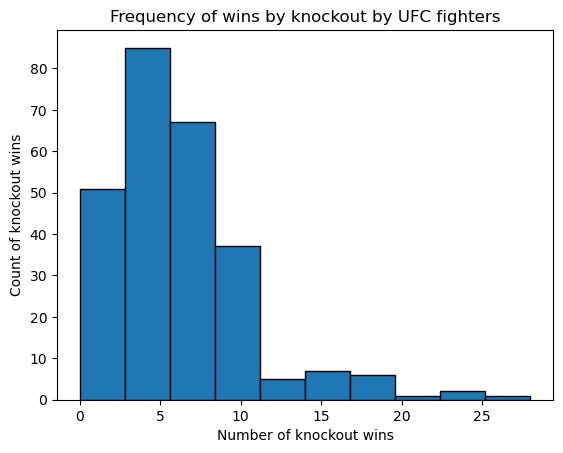

In [794]:
import matplotlib.pyplot as plt

     
plt.hist(total_df['wins_knockout'], ec="k") #ec="k" draws the lines between each bin. 

# adding title and labels
plt.title("Frequency of wins by knockout by UFC fighters")
plt.xlabel("Number of knockout wins")
plt.ylabel("Count of knockout wins")

plt.show()# to avoid clutter

Visible in the plot, there are some exceptional fighters with a high number of wins by knockout. But which is also visible is, that they are few. Thus, this plot is a good overview of the range of number of wins by knockout and how many of these we can count among the fighters but it does not give us a good sense of the distribution at the lower end (or from 0-10/11). To get a more fine grained impression, we could decide to remove these outer observations. However, for now, I find it adequate in providing an overview of the distribution as a whole.

#### Visualizing status_binary

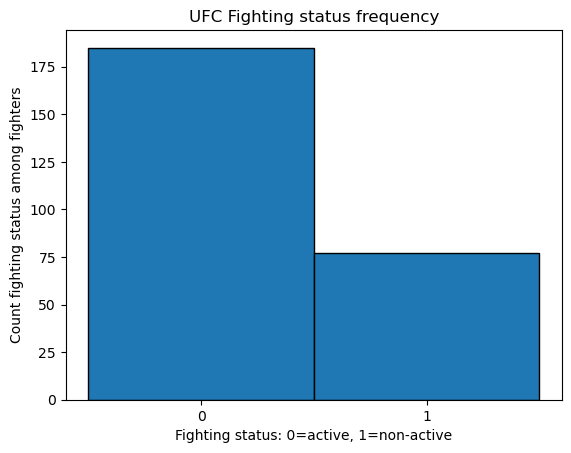

In [780]:
plt.hist(total_df['status_binary'], bins=[-.5,.5,1.5], ec="k")

# adding title and labels
plt.title("UFC Fighting status frequency")
plt.xlabel("Fighting status: 0=active, 1=non-active")
plt.ylabel("Count fighting status among fighters")
plt.xticks((0,1))

plt.show()# to avoid clutter


As written explicitly in the x-axis of the figure, the default of 0 = fighting and 1= not fighting. Most of the fighters are active, currently fighting, participating in Ufc fights, etc. However, the website also has some non-active fighters. How they organise this list, decide when to remove a non-active fighter from the website, etc. is unknown. But one could imagine they would keep high-ranking non-active fighters on the website for a while. For example, one very famous fighter, Khabib, retired in 2021 but is still on the website as people are still interested in his fighting statistics and information. Thus, it might make sense that UFC would only remove non-active fighters when they are no longer in people's interest. However, this is purely a thought.

For now, we can see the distribution of active and non-active fighters in the data frame.

#### 2. make two bivariate plots containing the outcome variable and two predictors  (one predictor per plot)

##### First bivariate plot: relationship between wins by knockout and reach. 

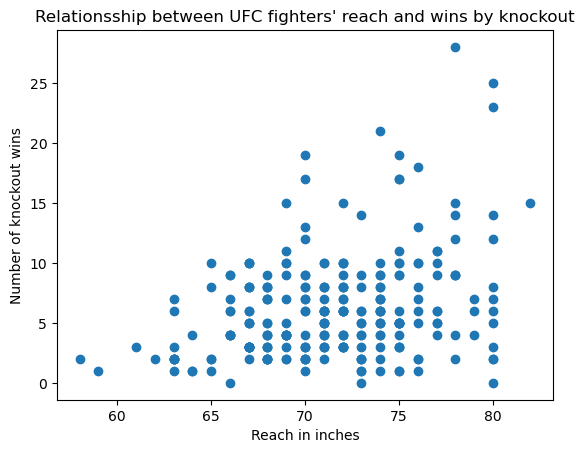

In [823]:
plt.scatter(total_df['reach'],total_df['wins_knockout'], )
# reach on the x axis (independent) and wins_knockout on the y axis (dependent)

# adds titles
plt.title("Relationsship between UFC fighters' reach and wins by knockout")
# adds x-axis label
plt.xlabel("Reach in inches")
# adds y-axis label
plt.ylabel("Number of knockout wins")
# add x-axis tick label

plt.show()

As the plot is self-contained with labels and titles, we can now interpret it. We can see an upwards trend, suggesting that there might be a relationship between the variables. However, much scatter indicates that if a relationship exists, it may be weak. 

##### Second bivariate plot: relationship between fighter status and number of wins 

As explained above, I will make a new variable, total_wins, which aggregates the values of the columns wins_knockout and wins_submission. This will be the independent variable. I do this before I move on to the plot.

In [ ]:
total_df['total_wins'] = total_df.apply(lambda row: row.wins_knockout +
                                  (row.wins_submission), axis = 1)

In [826]:
total_df

name                nickname         weight_class  \
0          Juan Adams            "The Kraken"          Heavyweight   
1     Zarrukh Adashev              "The Lion"            Flyweight   
2       Kevin Aguilar        "Angel of Death"        Featherweight   
3         Amir Albazi            "The Prince"            Flyweight   
4           José Aldo                     NaN         Bantamweight   
..                ...                     ...                  ...   
259     Polyana Viana         "Dama de Ferro"  Women's Strawweight   
260    Rodolfo Vieira                     NaN         Middleweight   
262  Cheyanne Vlismas  "The Warrior Princess"  Women's Strawweight   
263  Alexander Volkov                 "Drago"          Heavyweight   
264     Johnny Walker                     NaN    Light Heavyweight   

                                 twitter  \
0      https://twitter.com/chosenjuan285   
1           https://twitter.com/ZAdashev   
2    https://twitter.com/KevinAguilarAOD   
3         https://twitter.com/AmirAlbazi   
4     https://twitter.com/josealdojunior   
..                                   ...   
259    https://twitter.com/Polyanavianaa   
260                                  NaN   
262  https://twitter.com/CheyWarPrincess   
263  https://twitter.com/AlexDragoVolkov   
264     https://twitter.com/JohnnyWalker   

                                      ufc_profile  gender  wins_knockout  \
0          https://www.ufc.com/athlete/juan-adams       1              5   
1     https://www.ufc.com/athlete/zarrukh-adashev       1              2   
2       https://www.ufc.com/athlete/kevin-aguilar       1              9   
3         https://www.ufc.com/athlete/amir-albazi       1              5   
4           https://www.ufc.com/athlete/jose-aldo       1             17   
..                                            ...     ...            ...   
259     https://www.ufc.com/athlete/polyana-viana       0              5   
260    https://www.ufc.com/athlete/rodolfo-vieira       1              1   
262  https://www.ufc.com/athlete/cheyanne-vlismas       0              2   
263  https://www.ufc.com/athlete/alexander-volkov       1             23   
264     https://www.ufc.com/athlete/johnny-walker       1             15   

     wins_submission  striking_accuracy sig_str_landed_min  ...  reach  \
0                  0                  0               7.09  ...     80   
1                  0                  0               3.65  ...     65   
2                  2                  0               3.96  ...     72   
3                  9                  0               3.54  ...     68   
4                  1                  0               3.57  ...     70   
..               ...                ...                ...  ...    ...   
259                8                  0               3.50  ...     67   
260                7                  0               3.62  ...     73   
262                5                  0               4.93  ...     63   
263                3                  0               4.88  ...     80   
264                2                  0               3.26  ...     82   

      twitter_handle  follower_count following_count  tweet_count  \
0      chosenjuan285          6871.0           429.0       5300.0   
1           ZAdashev           360.0            65.0         77.0   
2    KevinAguilarAOD          1306.0           509.0        949.0   
3         AmirAlbazi          3895.0           214.0        564.0   
4     josealdojunior        949482.0           146.0       7602.0   
..               ...             ...             ...          ...   
259    Polyanavianaa         29931.0            38.0        161.0   
260              nan             NaN             NaN          NaN   
262  CheyWarPrincess         12674.0           291.0       5282.0   
263  AlexDragoVolkov          8685.0            78.0        152.0   
264     JohnnyWalker         66132.0           129.0       2420.0   

                

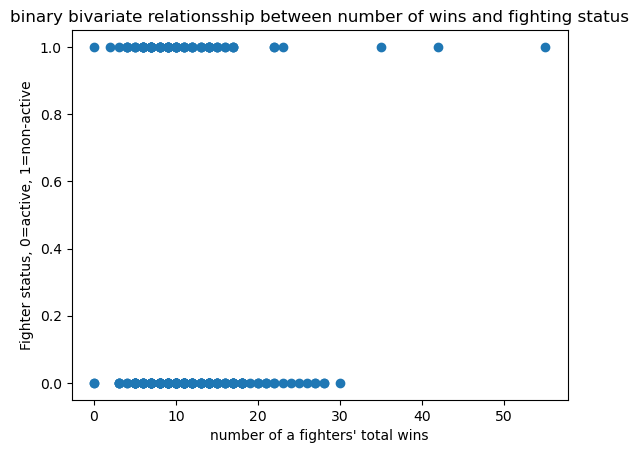

In [834]:
plt.scatter(total_df['total_wins'],total_df['status_binary'], )
# total wins on the x axis (independent) and status on the y axis (dependent)

# adds titles
plt.title("binary bivariate relationsship between number of wins and fighting status")
# adds x-axis label
plt.xlabel("number of a fighters' total wins")
# adds y-axis label
plt.ylabel("Fighter status, 0=active, 1=non-active")
# add x-axis tick label

plt.show()

As usual, it is difficult to extract much meaning from binary bivariate visualizations; all observations clutter at either 0 or 1, which makes sense given the variables' format. However, we might still be able to get a small sense of it. For example, we see that more fighters with a fighter status of non-active have a high number of wins. Logically, this might make sense: if a fighter now is retired, she/he might have had a long career with many many fights throughout it, resulting in many wins. A younger/newly accepted ufc fighter might not have had as many fights yet and thus, not many wins. 

____

## Section 5: Data Analysis 

The section is divided into several analyses: 

1. Linear regression 
2. Linear regression - control
3. Linear regression - categorical 
4. Logistic regression 
5. Logistic regression - interaction term
6. Squared term and/or log transformations


In [852]:
# packages needed for this section

import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

##### Linear regression 

As explained above, I want to conduct a linear regression model of the continuous outcome variable "wins_knockout" (wins by knockout) and the predictor variable "reach". 

I hypothesize a positive relationsship indicating wins by knockout to increase for each unit increase in reach. 

Thus, I want to conduct a linear regression model with the continuous "wins_knockout $Y_i$ as outcome and "reach" $X_i$ as predictor. In other words, I assume that the wins_knockout $Y_i$ is a function of the following:

$$
Y_i = \beta_0 + \beta_1X_i + \epsilon_i
$$

where the errors $\epsilon_i$ are independent, normally distributed variables with $E(\epsilon_i)=0$ and $SD(\epsilon_i)=\sigma$.

In [853]:
# estimating the model 

est_mod = ols('wins_knockout~reach', data=total_df).fit()

In the cell below, I print the estimates of the regression coefficients $\beta_0$ and $\beta_1$:

In [856]:
est_mod.params.round(2)

Intercept   -16.79
reach         0.32
dtype: float64

In [855]:
# finding sd 
np.sqrt(est_mod.scale).round(2)

4.12

In [892]:
# shown more clearly using stargazer

s = Stargazer([est_mod])
s

We thus get the following estimated relationship between wins by knockout and reach:

$$
E(Y_i) = -16.79 + 0.32X_i + \epsilon_i
$$

where $\epsilon_i$ are independent, normally distributed with $E(\epsilon_i)=0$ and $SD(\epsilon_i)=4.12$. 

Based on the model, it is possible to interpret the coefficients as follows: 
* the $\beta_0 $ acts as the 'intercept' or 'constant'. The value of $\beta_0 $, being -16.79, is thus the value of the dependent variable, wins by knockout, if the effect of the independent variable, reach, is 0. This does not make much sense in this instance, as no fighter have a reach=0 and thus, no  wins by knockout at -16.79. If I had been smart before conducting this analysis, I would have standardized the values of the data frame so that 0 in reach would have been the reach mean of the fighters instead. This would make the intercept more meaningful. But as always, there is more clarity in hindsight. 


* the $\beta_1 $ denotes the independent variable, reach. In this instance,  $\beta_1 $ is equal to 0.32. Thus, for each unit increase in reach, wins by knockout will be affected positively with a 0.32 increase. 

As is visible from the stargazer table above, the coefficient, reach, is significant. We can get this understanding as we see that reach has three stars next to it, indicating a p-value of p<0.01. This means that there is a smaller probability than 0.01 of getting such an estimate for reach if the true effect were actually zero. This also means that I can confirm my hypothesis that there is a positive relationship between reach and wins by knockout. 

If I think about this logically, this might be an underlying effect of the different fighters' weight classes - which I have not controlled for. All fighters are divided into weight classes, ensuring that no fighter has an unfair advantage if, for example, a huge fighter were up against a small fighter. In this instance, it would not (maybe to the same extent) be the techniques of the sport that mattered, but rather, the sheer volume of the body (as I assume that even though one is a master of jiu-jitsu, it might not matter if the opponent is twice one's size). In that sense, a smaller fighter, having a shorter reach, might have to punch his/her opponent several times to ensure a knockout - or maybe other techniques work more efficiently in lighter weight classes. A heavyweight fighter with a longer reach might only have to punch his/her opponent one time to ensure a win by knockout. Thus, it might be that winning by knockout is more common among higher weight classes and that weightclass is a confounding factor. I will control for this below. 


To circle back to the model itself, this is the model based on the actual observed data. In order for me to say more about the spread of the distribution and the usefulness of the model, I will use simulation and visualization. This will enable us to see clearly whether the model produces data that looks like the actual data in the total_df. 

I will use the code we used in 'Week 46 - Linear regression part 2' lecture to visualize the simulated data against the observed data. 




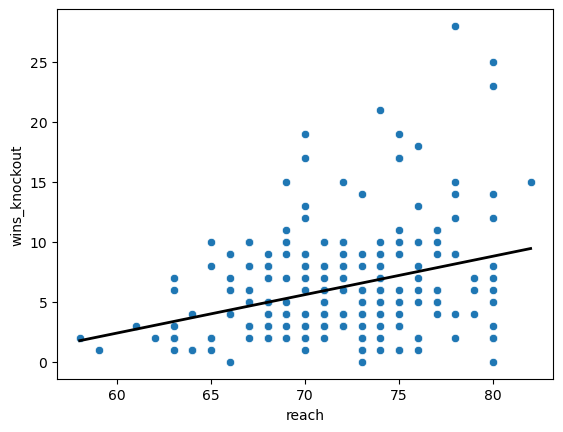

In [882]:
# first plotting the estimated relationship between wins_knockout (Y) and reach (X):

def est_exp_ko_win(x) : return -16.79 + 0.32*x

sns.scatterplot(data=total_df,x='reach',y='wins_knockout')
sns.lineplot(x=[total_df['reach'].min(),total_df['reach'].max()],
             y=[est_exp_ko_win(total_df['reach'].min()),est_exp_ko_win(total_df['reach'].max())],
             color='black',linewidth=2);

At first, I did not understand why the intercept was not intercepting at -16.79 as estimated in the model. However, this is because the intercept is the value of wins_knockout when reach has a value of 0. This means that the range of reach on the x-axis does not operate below approx. 55 and, thus, do not show the actual intercept. The plot indicates a positive relationship, but there is quite a bit of scatter - this may also be more evident as the plot is zoomed in. 

In [875]:
# simulating data

def sim_lin_reg_mod(beta0, beta1, sigma, xs, col_names) :
    ys = beta0 + beta1*xs + np.random.normal(0,sigma,xs.shape[0])
    sim = pd.DataFrame(zip(xs,ys),columns=col_names)
    return sim

np.random.seed(0)
ko_sims = [sim_lin_reg_mod(-16.79, 0.32, 4.12, total_df['reach'], ['reach','wins_knockout']) for i in range(0,5)]
ko_sims[0]

reach  wins_knockout
0       80      16.077896
1       65       5.658648
2       72      10.282400
3       68      14.202480
4       70      13.304339
..     ...            ...
251     67       2.277754
252     73       7.154847
253     63       2.054367
254     80      11.659140
255     82      12.312366

[256 rows x 2 columns]

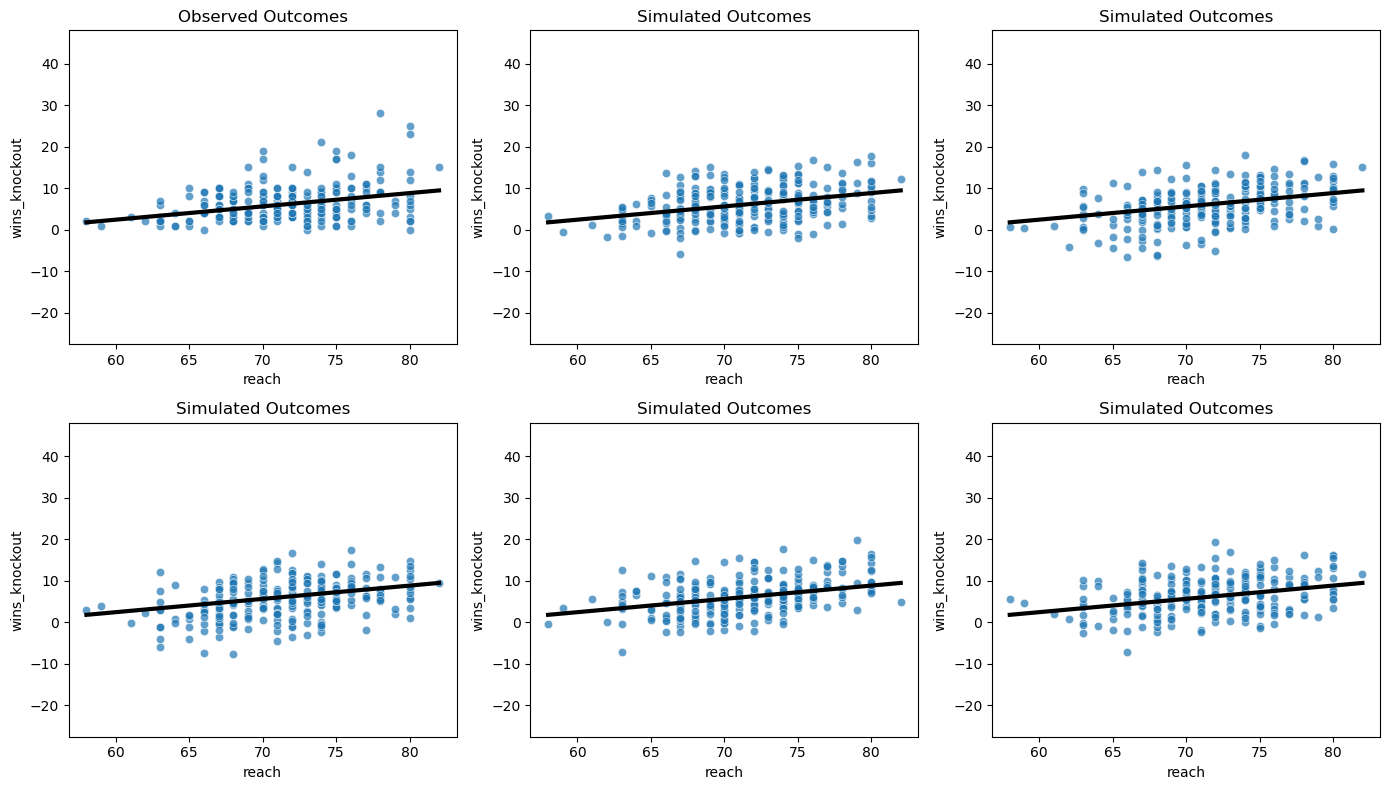

In [885]:
# plotting the observed data and simulated

dfs_plot = [total_df] + ko_sims

min_y = pd.concat(dfs_plot)['wins_knockout'].min()
max_y = pd.concat(dfs_plot)['wins_knockout'].max()

fig,ax = plt.subplots(2,3,figsize=(14,8))

for i in range(0,6) :
    dat = dfs_plot[i]
    a = ax.flatten()[i]
    sns.scatterplot(data=dat,x='reach',y='wins_knockout',ax=a, alpha=0.70) # alpha denoting hue of observations
    
    sns.lineplot(x=[total_df['reach'].min(),total_df['reach'].max()],
             y=[est_exp_ko_win(total_df['reach'].min()),est_exp_ko_win(total_df['reach'].max())],
             color='black',linewidth=3,ax=a);
    
    if i==0 :
        tit = 'Observed Outcomes'
    else :
        tit = 'Simulated Outcomes'
    a.set(title=tit,ylim=[min_y-20,max_y+20])

plt.tight_layout()

Generally, I think the estimated model produces data that looks similar to the actual data. Yet, I think it seems like there is less deviation in the observed data for fighters with shorter reach compared to the simulated outcomes for fighters with short reach. Also, it seems as if there is more deviation for fighters with a longer reach in the observed data compared to fighters with a longer reach in the simulated outcomes. 

This may indicate that there is a problem with the assumption that the standard deviation of the errors $SD(\epsilon_i)=\sigma$ for all $i$, as this limits the standard deviation from being lower when reach is shorter and also limits standard deviation from being higher when the reach is longer.

Below, I will, among others, look into this problem by simulating and estimating the errors. For this task, I will follow the step from the lecture "Week 46 - Linear regression part 3". 

__

As I am interested in calculating the errors $\epsilon_i$ according to the estimated model (where we assume these to be normally distributed), first step in doing do is to calculated the estimated $E(Y_i)$, that is, the outcome for each fighter - the wins by knockout for each fighter. 

I will do so as follows: 


In [886]:
ko_estmod = total_df[['reach','wins_knockout']].copy()
ko_estmod['exp_y'] = est_mod.predict() 
ko_estmod

reach  wins_knockout     exp_y
0       80              5  8.962074
1       65              2  4.133051
2       72              9  6.386595
3       68              5  5.098855
4       70             17  5.742725
..     ...            ...       ...
259     67              5  4.776921
260     73              1  6.708530
262     63              2  3.489181
263     80             23  8.962074
264     82             15  9.605944

[256 rows x 3 columns]

In [887]:
# now I have the estimated outcomes for each fighter. Now we can calculate the difference in estimated 
# outcome for each fighter and actual observed outcome for each fighter. This difference between estmated
# and actual outcome for each fighter are the errors/residuals. 

ko_estmod['err'] = ko_estmod['wins_knockout'] - ko_estmod['exp_y']
ko_estmod


reach  wins_knockout     exp_y        err
0       80              5  8.962074  -3.962074
1       65              2  4.133051  -2.133051
2       72              9  6.386595   2.613405
3       68              5  5.098855  -0.098855
4       70             17  5.742725  11.257275
..     ...            ...       ...        ...
259     67              5  4.776921   0.223079
260     73              1  6.708530  -5.708530
262     63              2  3.489181  -1.489181
263     80             23  8.962074  14.037926
264     82             15  9.605944   5.394056

[256 rows x 4 columns]

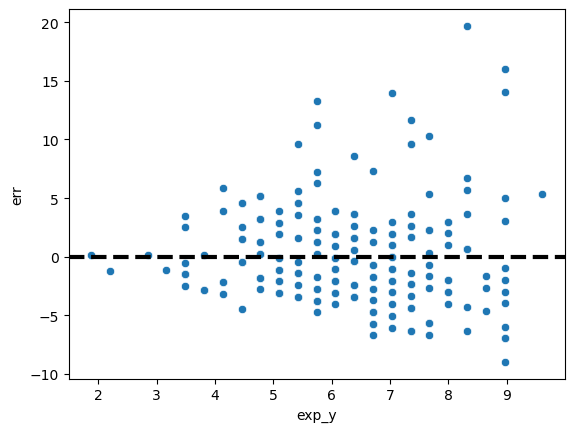

In [888]:
# now that the estimated errors are calculated, we can visualize these errors against the estimated wins by 
# knockout (exp_y): 


ax = sns.scatterplot(data=ko_estmod, x='exp_y', y='err')
ax.axhline(color='black',linestyle='--',linewidth=3);

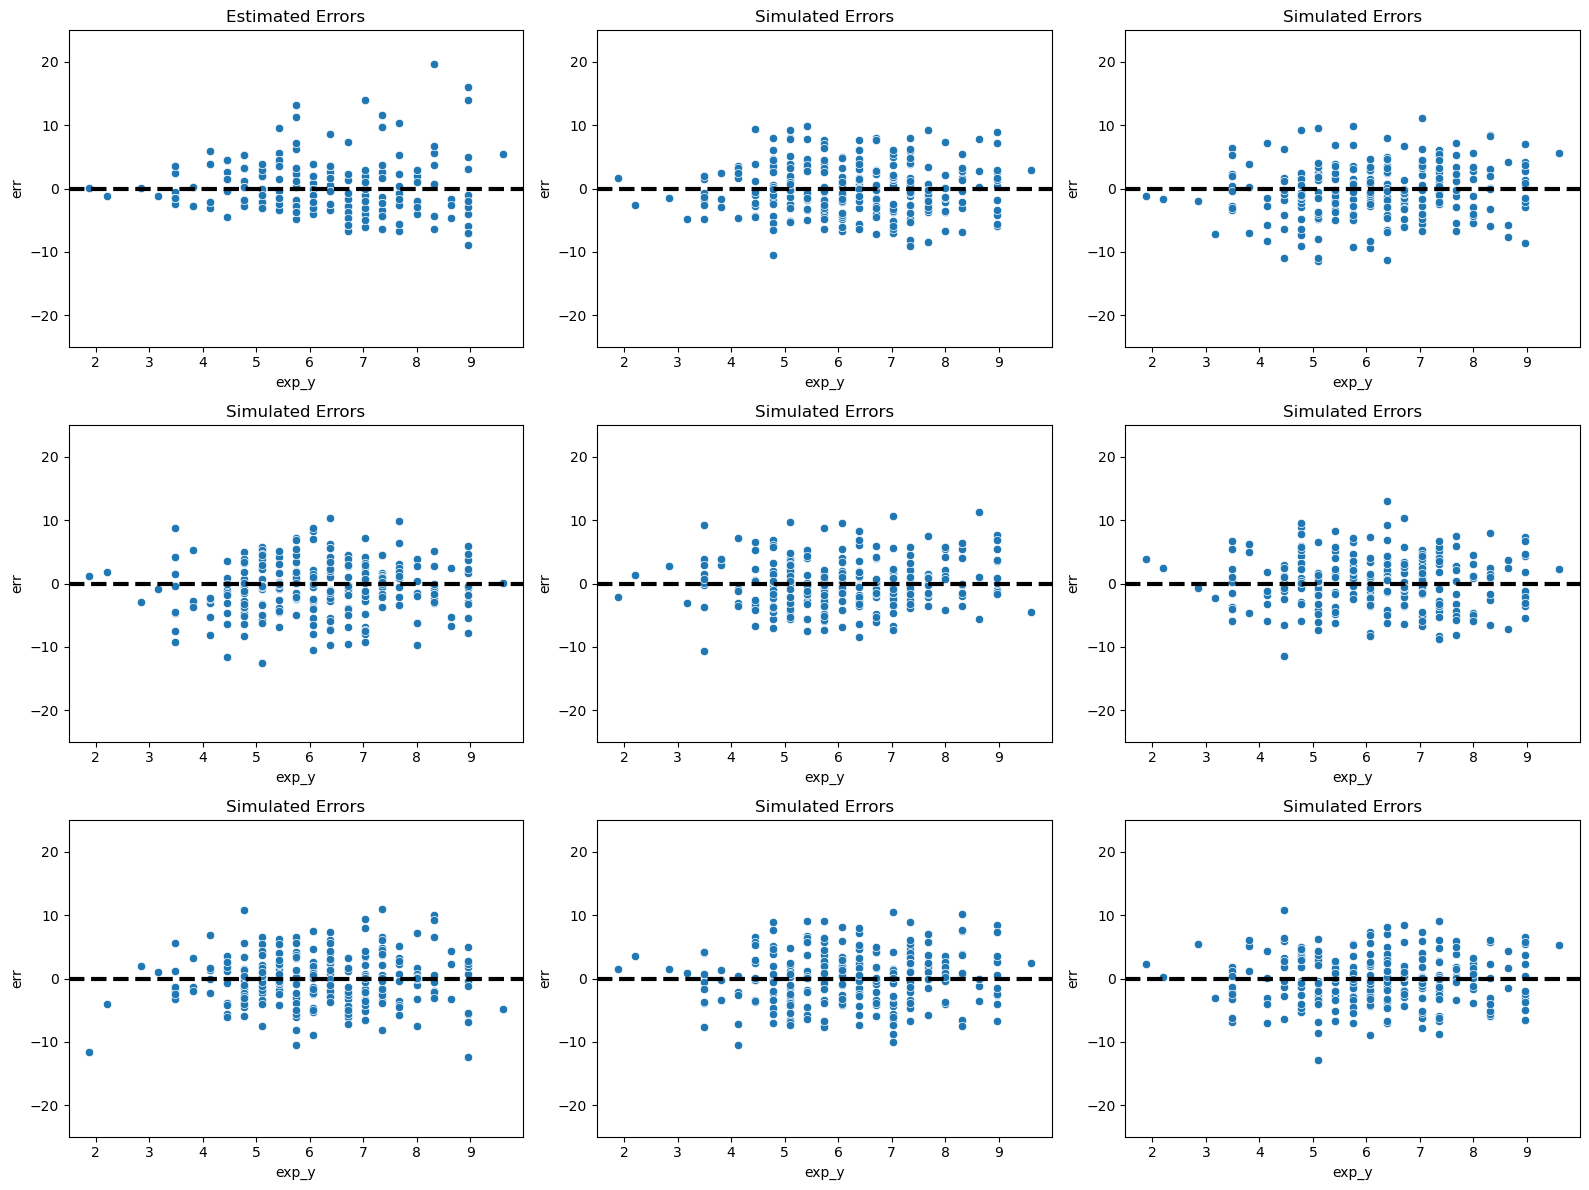

In [891]:
# making scatterplots of errors that are simulated according to the estimated model. 
# I am making 8 simulations (not for any specfic reason other than to see many simulations). 

np.random.seed(0)
errs_sim = [np.random.normal(0, 4.12, 256) for i in range(0,8)] 
                            #0 for mean of errors according to the assumptions of the model
                            # 4.12 for the standard deviation 
                            # 256 for n fighters in the dataset
            
errs_plot = [ko_estmod['err']] + errs_sim 

fig, ax = plt.subplots(3,3,figsize=(16,12))

for i in range(0,9) :
    errs = errs_plot[i]
    a = ax.flatten()[i]
    sns.scatterplot(x=ko_estmod['exp_y'],y=errs,ax=a)
    a.axhline(color='black',linestyle='--',linewidth=3);
    
    if i==0 :
        tit = 'Estimated Errors'
    else :
        tit = 'Simulated Errors'
    a.set(title=tit,xlabel='exp_y',ylabel='err',ylim=[-25,25]) # setting the limitations of the y axis 
                                                               # so that it fits the data 

plt.tight_layout()

By comparing the distribution of errors between the estimated errors and simulated errors, it is visible that they are not completely similar. The simulated errors look more similar to each other where the estimated errors'  spread gets larger as the expected y, the wins by knockout, gets larger. As was suggested in my interpretation of the plots above, this may indicate that the assumption of constant standard deviation of errors (homoskedasticity) is violated. 

Another assumption for the linear regression model is the assumption of normality. It is possible to check for this using a qq plot as below: 



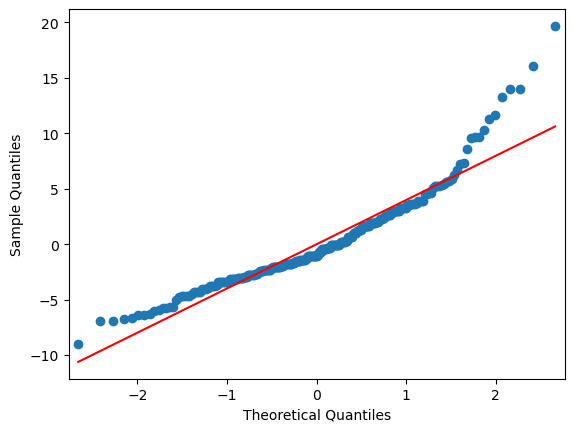

In [894]:
import statsmodels.api as sm
sm.qqplot(ko_estmod['err'],line='r')
plt.show()

As the qqplot shows that all errors do not follow the red line, we cannot assume normally distributed errors and thus, the normality assumption is also violated. 

These violated assumptions of both normality of errors, and homoscedasticity hurt the reliability of the coefficients we found above. We thus have to estimate the coefficients again and change the model's assumptions. With the violated assumptions removed, we now have the following assumptions for the model: 

$$
Y_i = \beta_0 + \beta_1X_i + \epsilon_i
$$

where $\epsilon_i$ are independent random variables (NOT independent, normally distributed) with  $E(\epsilon_i)=0$ and $SD(\epsilon_i)=\sigma$. 

As the errors do not have the same standard deviation (they are heteroskedastic), we will estimate the coefficients using the robust 95% confidence intervals, which, when approaching the central limit theorem, can still be useful. Even though I might not actually be able to assume that my dataset is large enough to be able to interpret the robust confidence interval (as n= 256), I will continue as if for the sake of this exam. However, note that I, in practice, would suggest a larger sample or that the entire population were to be studied (all UFC fighters).




In [895]:
est_mod.get_robustcov_results(cov_type='HC3').summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

The estimates ended up being the same as above. Thus, it should be mentioned that there might be a reliability issue with these coefficients. If this analysis were to be conducted again, a a larger sample (or here, all ufc fighters information) would be needed. 

Below, I will briefly interpret this confidence interval.

The estimate for the regression coefficient $\beta_0$ is -16.77. The confidence interval is $[-25.98,\ -7.60]$. 

We can interpret this interval of values as follows: for the actual data, the confidence interval has a 95% probability for including $\beta_0$ given that the estimates were generated according to the assumed model. That is, if I draw 100 samples using this model and a 95% confidence interval was calculated for each,  then 95 of the times, these intervals would contain the value of the $\beta_0$. According to the estimates in the CI now, it does indeed cover $\beta_0$, which is -16.79. 

This is exactly the samme approach for the coefficient of reach, where the CI is $[0.19,\ 0.45]$ and the $\beta_1$ is within it at 0.32. 

Now, as I made a teaser for above, I have a theory that the estimate for reach is an underlying effect for the different weight classes and that it, in reality, is the weight classes that explain how many wins by knockout there are. Below, I will first conduct a linear regression model as above but include weightclass as a control. Afterwards, I will conduct a linear regression model for wins by knockout, with the only predictor being the weight classes. 

___ 

### Linear regression - controlling for weight classes

I will conduct the same model as above but include the categorical variable of weight classes as a control. I chose weight class as my control as I suspect this actually explains the finding. I intend not to remove weight classes based on gender.


With wins by knockout as outcome (Yi) and the predictors of reach and weightclass and the same assumptions as  above, the model is written as follows: 

$$
Y_i = \beta_0 + \beta_1 X_{i,1} + \beta_2 X_{i,2} + \beta_3 X_{i,3} + \beta_4 X_{i,4}+ \beta_5 X_{i,5}+ \beta_6 X_{i,6} + \beta_7 X_{i,7} + \beta_8 X_{i,8} + \beta_9 X_{i,9} + \beta_10 X_{i,10}+ \beta_11 X_{i,11}+  \beta_ 12 X + \epsilon_i
$$

where $\epsilon_i$ are independent random variables with  $E(\epsilon_i)=0$ and $SD(\epsilon_i)=\sigma$. 

Thus, the categorical values is written as follows depending on the weight class of interest: 

- $X_{i,1} = 1$ if $i$ indicate featherweight, else 0
- $X_{i,2} = 1$ if $i$ indicate flyweight, else 0
- $X_{i,3} = 1$ if $i$ indicate heavyweight, else 0
- $X_{i,4} = 1$ if $i$ indicate heavyweight, else 0
- $X_{i,5} = 1$ if $i$ indicate lightweight, else 0
- $X_{i,6} = 1$ if $i$ indicate middleweight, else 0
- $X_{i,7} = 1$ if $i$ indicate welterweight, else 0
- $X_{i,8} = 1$ if $i$ indicate bantamweight, else 0
- $X_{i,9} = 1$ if $i$ indicate featherweight, else 0
- $X_{i,10} = 1$ if $i$ indicate flyweight, else 0
- $X_{i,11} = 1$ if $i$ indicate strawweight, else 0

In [897]:
# counting how many weightclasses there are
total_df['weight_class'].nunique()

12

In [906]:
# wanting the names of the different weight classes
print(total_df['weight_class'].unique())

['Heavyweight' 'Flyweight' 'Featherweight' 'Bantamweight' 'Middleweight'
 'Lightweight' "Women's Featherweight" 'Light Heavyweight'
 "Women's Flyweight" 'Welterweight' "Women's Bantamweight"
 "Women's Strawweight"]


In [918]:
# Using C() to dummy code the categorical variable weight class

est_mod_2 = ols('wins_knockout~C(weight_class)+reach', data=total_df).fit() 

est_mod_2.get_robustcov_results(cov_type='HC3').summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>


I admit, this looks a little confusing. Unfortunately, the different weightclasses are not sorted either. 
But it is, nevertheless, informative. 

First, and for my own sake, I will just list the weightclasses from lowest to hight: 

* Strawweight (only womens strawweight in this dataset)
* Flyweight
* Bantamweight
* Featherweight
* Lightweight
* Welterweight
* Middleweight
* Light Heavyweight
* Heavyweight


I could have chosen a continuous variable as my control or one with fewer categories, but given weightclass made logically sense to me to investigate, I will interpret the coeffiecients as follows, with focus on the control: 
* Intercept: the model predicts that fighters at bantam weight with no reach will have -2.3 wins by knockout. It makes no sense here that reach = 0, but when arm length are inserted below, it will be more clear. 


* Reach: the model predicts that, holding weight classes constant, one unit increase in reach is associated with 0.13 more wins by knockout. 


* Betas : these shows the effect of going from one group to the other, starting from the intercept, assuming the reach variable is constant. That is, they denote the mean difference in wins by knockout between the different weight classes if reach were the same in each group. 



Compared to the first model that only considered reach, wins by knockout increased by 0.32 for each unit increase in reach, where it only increases by 0.12 for each unit increase in reach in this model. Thus, its explanatory power has decreased and actually, is not relevant anymore: As the CI for reach includes zero, I can conclude that reach is not statistically significant and that the reason for its signficance in the model above was its association with weight class. 

The table above thus supports my belief that it is weight class that explains wins by knockout rather than reach; and the heavier the fighter, the more wins by knockout. 

The dummy variable, i.e., the reference category is bantam weight. This means that when interested in estimating the average wins by knowckout for bantamweight with a reach of X, the outcome is simply $\beta_0 + \beta_(12) $. For other categories, it is the reference groups coefficient + the coefficient of the given weightgroup. This is also visible below.

In all but the heaviest weight class, there is a negative relationsship between wins by knockout and weight class. This relationsship is most negative among light weightclasses and increases as the weight class increases. 
___

For a fighter within the weight class of womens strawweight, the estimated average wins by knockout would be: 


$$
Y_i = \beta_0 + \beta_1 * 1  + \beta_2 *0 + \beta_3 *0 + \beta_4 *0 + \beta_5 *0+ \beta_6 *0 + \beta_7 *0 + \beta_8 *0 + \beta_9 *0 + \beta_10 *0+ \beta_(11) *0+ \beta_(12) + \epsilon_i
$$

which, simplified (as all the other categorical variables are equal 0 when womens strawweight is equal 1), is:


$$
Y_i = \beta_0 + \beta_(11) + \beta_(12)
$$


That is:

$$
3.12 = -2.3 + -3.03 + 0.13*65 
$$


** x=65  is chosen here as the unit as I googled that the average UFC womens strawweight fighter has a reach of 65 inches. 

___

For a fighter within the weight class of feather weight, the estimated average wins by knockout would be: 

$$
Y_i = \beta_0 + \beta_1 *0 + \beta_2 *0 + \beta_3 *0 + \beta_4 *0 + \beta_5 *0+ \beta_6 *0 + \beta_7 *0 + \beta_8 *0 + \beta_9 *0 + \beta_10 *0+ \beta_(11) *1 + \beta_(12) + \epsilon_i
$$

which, simplified (as all the other categorical variables are equal 0 when featherweight is equal 1), is:

$$
Y_i = \beta_0 + \beta_1 + \beta_(12)
$$


That is:

$$
5.02 = -2.3 + -1.78 + 0.13*70 
$$

** x=70 is chosen here as the unit as I googled that the average UFC featherweight fighter has a reach of 70 inches. 


___

For a fighter within the weight class of heavy weight, the estimated average wins by knockout would be: 


$$
Y_i = \beta_0 + \beta_1 *0 + \beta_2 *0 + \beta_3 *1 + \beta_4 *0 + \beta_5 *0+ \beta_6 *0 + \beta_7 *0 + \beta_8 *0 + \beta_9 *0 + \beta_10 *0+ \beta_(11) *0+ + \beta_(12) + \epsilon_i
$$

which, simplified (as all the other categorical variables are equal 0 when featherweight is equal 1), is:

$$
Y_i = \beta_0 + \beta_3 + \beta_(12)
$$


That is:

$$
11.05 = -2.3 + 3.27 + 0.13*77.5 
$$

** x=77.5 is chosen here as the unit as I googled that the average UFC heavyweight fighter has a reach of 77.5 inches. 


___

##### BUT
From the CI, it is also evident that not all weight classes are significant. 

I will present the coefficients and their p values more clearly with the stargazer table below.

In [925]:
# calculating estimated wins by knockout for womens strawweight

-2.3 + -3.03 + 0.13*65 

3.120000000000001

In [926]:
# calculating estimated wins by knockout for featherweight
-2.3 + -1.78 + 0.13*70 

5.02

In [927]:
# calculating estimated wins by knockout for heavyweight
-2.3 + 3.27 + 0.13*77.5 

11.045000000000002

In [910]:
s_weight = Stargazer([est_mod_2])
s_weight

Here it is more manageable to see significance. 


That is, only the weight classes of featherweight, heavyweight, and women's strawweight are significant. Above, I interpreted and calculated the outcome for the significant coefficients instead of for each and every coefficient, as I have chosen a variable with many categories. I hope this is sufficient. 

Even though there are significant coefficients, it should be noted that the sample is small, and due to the many different weight classes, there are few observations within each. The results are thus not very reliable as there are not enough observations to approach the central limit theorem and, thus, 1) can represent a different reflection of reality and 1) cannot be generalized. Furthermore, as I conducted this second linear regression analysis with the assumption of error as independent and random (not normally distributed), I used the robust confidence interval as well. But for good measure, I will check the distribution of errors to see if the assumptions continue to be violated. I do this below by making a qq plot.

In [921]:
# counting the different observations in each weight class 

total_df['weight_class'].value_counts()

Middleweight             37
Lightweight              36
Featherweight            33
Bantamweight             29
Welterweight             25
Flyweight                18
Light Heavyweight        17
Women's Flyweight        16
Women's Strawweight      16
Heavyweight              15
Women's Bantamweight     11
Women's Featherweight     3
Name: weight_class, dtype: int64

In [919]:
# Pre steps in getting the qq plot.  

# first adding columns in a copy of the dataset with expected y for each fighter + residuals

df_weight = total_df.copy()
df_weight['exp_y'] = est_mod_2.predict()
df_weight['res'] = est_mod_2.resid
df_weight

name                nickname         weight_class  \
0          Juan Adams            "The Kraken"          Heavyweight   
1     Zarrukh Adashev              "The Lion"            Flyweight   
2       Kevin Aguilar        "Angel of Death"        Featherweight   
3         Amir Albazi            "The Prince"            Flyweight   
4           José Aldo                     NaN         Bantamweight   
..                ...                     ...                  ...   
259     Polyana Viana         "Dama de Ferro"  Women's Strawweight   
260    Rodolfo Vieira                     NaN         Middleweight   
262  Cheyanne Vlismas  "The Warrior Princess"  Women's Strawweight   
263  Alexander Volkov                 "Drago"          Heavyweight   
264     Johnny Walker                     NaN    Light Heavyweight   

                                 twitter  \
0      https://twitter.com/chosenjuan285   
1           https://twitter.com/ZAdashev   
2    https://twitter.com/KevinAguilarAOD   
3         https://twitter.com/AmirAlbazi   
4     https://twitter.com/josealdojunior   
..                                   ...   
259    https://twitter.com/Polyanavianaa   
260                                  NaN   
262  https://twitter.com/CheyWarPrincess   
263  https://twitter.com/AlexDragoVolkov   
264     https://twitter.com/JohnnyWalker   

                                      ufc_profile  gender  wins_knockout  \
0          https://www.ufc.com/athlete/juan-adams       1              5   
1     https://www.ufc.com/athlete/zarrukh-adashev       1              2   
2       https://www.ufc.com/athlete/kevin-aguilar       1              9   
3         https://www.ufc.com/athlete/amir-albazi       1              5   
4           https://www.ufc.com/athlete/jose-aldo       1             17   
..                                            ...     ...            ...   
259     https://www.ufc.com/athlete/polyana-viana       0              5   
260    https://www.ufc.com/athlete/rodolfo-vieira       1              1   
262  https://www.ufc.com/athlete/cheyanne-vlismas       0              2   
263  https://www.ufc.com/athlete/alexander-volkov       1             23   
264     https://www.ufc.com/athlete/johnny-walker       1             15   

     wins_submission  striking_accuracy sig_str_landed_min  ...  \
0                  0                  0               7.09  ...   
1                  0                  0               3.65  ...   
2                  2                  0               3.96  ...   
3                  9                  0               3.54  ...   
4                  1                  0               3.57  ...   
..               ...                ...                ...  ...   
259                8                  0               3.50  ...   
260                7                  0               3.62  ...   
262                5                  0               4.93  ...   
263                3                  0               4.88  ...   
264                2                  0               3.26  ...   

     follower_count following_count  tweet_count  \
0            6871.0           429.0       5300.0   
1             360.0            65.0         77.0   
2            1306.0           509.0        949.0   
3            3895.0           214.0        564.0   
4          949482.0           146.0       7602.0   
..              ...             ...          ...   
259         29931.0            38.0        161.0   
260             NaN             NaN          NaN   
262         12674.0           291.0       5282.0   
263          8685.0            78.0        152.0   
264         66132.0           129.0       2420.0   

                                           tweets_text  ufc_count fight_count  \
0    [Just posted a photo https://t.co/X9OUsnEa9s, ...          0           0   
1    [@AliAbdelaziz00 Agree 100% MMA striking and K...          2           1   
2    [145lb perfect  weight cut https://t.co/hQ31mI...       

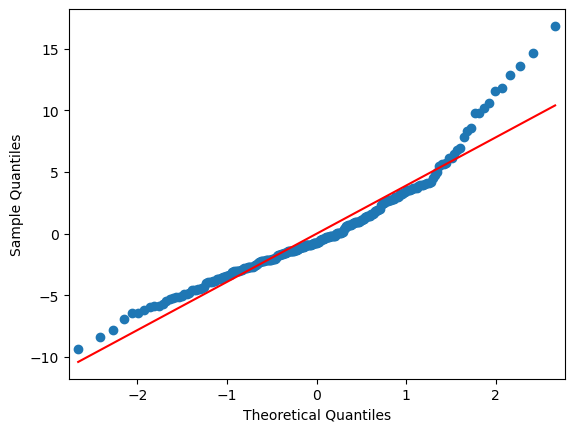

In [920]:
sm.qqplot(df_weight['res'],line='r')
plt.show()

As i suspected, the residuals are heteroskedastic in this model as well and therefore it made sense to use the robust CI. However, given the small sample size, this probably reveals the same estimates as the normal CI. 

For future analysis of the same, one should thus extract information on much more fighters to be able to assess its actual significance. 

### Linear regression - non-binary categorical variable as the predictor 

The exam description did, among others, dictate to 1) conduct a linear regression with a control and 2) conduct a linear regression with a non-binary categorical variable as a predictor. I conducted a linear regression in the above analysis with a non-binary categorical variable as predictor and control. However, to be certain that I fulfil the criteria of this exam, I will briefly conduct a linear regression model as above, but this time only using weight class as predictor. 

I will follow the same assumptions as above (that is, I will not visualize and assess the errors again here) for this model. 

It remains the same, except that reach is excluded. The model is as follows: 

With wins by knockout as outcome (Yi) and the predictor of weightclass, the model is written as follows: 

$$
Y_i = \beta_0 + \beta_1 X_{i,1} + \beta_2 X_{i,2} + \beta_3 X_{i,3} + \beta_4 X_{i,4}+ \beta_5 X_{i,5}+ \beta_6 X_{i,6} + \beta_7 X_{i,7} + \beta_8 X_{i,8} + \beta_9 X_{i,9} + \beta_10 X_{i,10}+ \beta_11 X_{i,11}+  \epsilon_i
$$


where $\epsilon_i$ are independent random variables with  $E(\epsilon_i)=0$ and $SD(\epsilon_i)=\sigma$. 



In [922]:
# Using C() to dummy code the categorical variable weight class

est_mod_3 = ols('wins_knockout~C(weight_class)', data=total_df).fit() 

est_mod_3.get_robustcov_results(cov_type='HC3').summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [923]:
# using stargazer for better overview

s_weight_2 = Stargazer([est_mod_3])
s_weight_2

       

As in the latter model, heavyweight and women's strawweight are significant. Furthermore, women's bantamweight and women's flyweight are significant in this model. However, very few fighters are included in the women's weight classes and stating that these, in truth, are significant may be very wrong. 

As it was not significant above, I did not interpret the intercept coefficient. However, as it is the case here, I will do it as to demonstrate that I am aware of what it means when the intercept is significant: 

Once again, it is the bantam weight that is the reference group. The function is then the following:


$$
Y_i = \beta_0 + \beta_1 *0 + \beta_2 *0 + \beta_3 *0 + \beta_4 *0 + \beta_5 *0+ \beta_6 *0 + \beta_7 *0 + \beta_8 *0 + \beta_9 *0 + \beta_10 *0+ \beta_11 *0+ + \epsilon_i
$$

As X = 0 for all  categories, as we are interested in the reference group, all these are cancelled out. 
In the end, the function is:

$$
Y_i = \beta_0 
$$


Which, according to the model is the following for fighters within the bantamweight class:


wins  by  knockout = 6.69


As is visible from the table, the p-values for the significant coefficients are not all the same. What this means is that there are different probabilities: 
* p<0.01 indicate that there is a smaller probability than 0.01 of getting such an estimate if the true effect were actually zero.
* p<0.05 indicate same as above, just with a probability of 0.05 here instead. 
* p<0.1 indicate same as above, just with a probability of 0.1 here instead. 

The smaller the p-value, the smaller the probability and the more reliable the result. 
That said, even though some of the coefficients are significant in this dataset, I cannot generalize to ufc fighters at large, but only comment on the fighters in the dataset which are filtered based on fighting style. This means that the sample may not be representative of the population, being all ufc fighters.

### Logistic regression 

As explained in the beginning of the analysis section, I will conduct a logistic regression model of the binary outcome variable "status_binary" and the predictor variable "total wins". 

I hypothesize that there is a relationship. With this, I have two rather opposite theories: 
1. Each unit increase in number of wins is associated with increase in fighter status. This is derived from the thought that the more wins you have, the more it suggests a longer career, the more I rationalize the fighter to be retired now and thus, are not fighting. 
2. Each unit increase in number of wins is associated with decrease in fighter status. This is derived from the thought that if you, as a fighter, never win, you might be more likely to stop in the UFC as you dont have what it takes. So for each win, there is a decrease in fighter status towards 0=active.

In [837]:
#defining and fitting the model: 

log_reg = smf.logit("status_binary ~ total_wins", data=total_df).fit()

Optimization terminated successfully.
         Current function value: 0.607310
         Iterations 5


In [840]:
#the confidence interval does overlap 0, so we can assume that the relationsship is not significant

log_reg.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [841]:
# making it even more clear by running stargazer

s1 = Stargazer([log_reg])
s1

Besides saying that the relationsship is not significant, we cannot really say much else about the coefficients from this table. Or at least, we cannot apply the interpretation of the linear regression in the same way to the logistic regression. The reason for this is that the function for logistic regression differs  from the linear regression and that the relationsship is not linear but instead follows a sigmoid curve.

Instead, we will try to derive interpretability from using predicted probabilities. This is done below: 

In [848]:
# fist sorting the values according to the total_wins variable so that the plot will look reasonable. 
# I change the indexes according to this new sorting as not to confuse myself below when the predicted
# probabilities are listed next to the indexes. 

log_df = total_df.sort_values("total_wins", ascending = False)
log_df = log_df.reset_index(drop=True)
log_df

name               nickname       weight_class  \
0      Aleksei Oleinik  "The Boa Constrictor"        Heavyweight   
1     Alistair Overeem   "The Demolition Man"        Heavyweight   
2         Ben Rothwell                    NaN        Heavyweight   
3     Charles Oliveira             "Do Bronx"        Lightweight   
4      Glover Teixeira                    NaN  Light Heavyweight   
..                 ...                    ...                ...   
251  Katlyn Chookagian       "Blonde Fighter"  Women's Flyweight   
252    Zarrukh Adashev             "The Lion"          Flyweight   
253      Aaron Jeffery                    NaN       Middleweight   
254      Justin Sumter             "The Fort"       Middleweight   
255         TJ Laramie                    NaN      Featherweight   

                                 twitter  \
0         https://twitter.com/oleynikufc   
1    https://twitter.com/AlistairOvereem   
2    https://twitter.com/RothwellFighter   
3    https://twitter.com/CharlesDoBronxs   
4     https://twitter.com/gloverteixeira   
..                                   ...   
251    https://twitter.com/BlondeFighter   
252         https://twitter.com/ZAdashev   
253           https://twitter.com/AAJMMA   
254    https://twitter.com/FortSumterMMA   
255        https://twitter.com/laramietj   

                                       ufc_profile  gender  wins_knockout  \
0      https://www.ufc.com/athlete/aleksei-oleinik       1              8   
1     https://www.ufc.com/athlete/alistair-overeem       1             25   
2         https://www.ufc.com/athlete/ben-rothwell       1             28   
3     https://www.ufc.com/athlete/charles-oliveira       1              9   
4      https://www.ufc.com/athlete/glover-teixeira       1             18   
..                                             ...     ...            ...   
251  https://www.ufc.com/athlete/katlyn-chookagian       0              2   
252    https://www.ufc.com/athlete/zarrukh-adashev       1              2   
253      https://www.ufc.com/athlete/aaron-jeffery       1              0   
254      https://www.ufc.com/athlete/justin-sumter       1              0   
255         https://www.ufc.com/athlete/tj-laramie       1              0   

     wins_submission  striking_accuracy sig_str_landed_min  ...  reach  \
0                 47                  0               3.29  ...     80   
1                 17                  0               3.67  ...     80   
2                  7                  0               3.71  ...     78   
3                 21                  0               3.48  ...     74   
4                 10                  0               3.80  ...     76   
..               ...                ...                ...  ...    ...   
251                1                  0               4.59  ...     68   
252                0                  0               3.65  ...     65   
253                0                  0               3.10  ...     73   
254                0                  0               2.68  ...     80   
255                0                  0               1.49  ...     66   

      twitter_handle  follower_count following_count  tweet_count  \
0         oleynikufc         19772.0            92.0       2486.0   
1    AlistairOvereem        485519.0          1683.0       7604.0   
2    RothwellFighter         31846.0          1187.0       4254.0   
3    CharlesDoBronxs        399977.0           133.0       2654.0   
4     gloverteixeira        139506.0           231.0       4063.0   
..               ...             ...             ...          ...   
251    BlondeFighter             NaN             NaN          NaN   
252         ZAdashev           360.0            65.0         77.0   
253           AAJMMA          1488.0           591.0       2481.0   
254    FortSumterMMA           791.0          1195.0       2540.0   
255        laramietj             NaN             NaN          NaN   

                             

In [849]:
# This then lists the predicted probability for fighter status for each fighters' number of wins

wins_predict = log_reg.predict(log_df['total_wins'])
wins_predict

0      0.182257
1      0.212470
2      0.230189
3      0.243466
4      0.248920
         ...   
251    0.323655
252    0.326880
253    0.333379
254    0.333379
255    0.333379
Length: 256, dtype: float64

<AxesSubplot:xlabel='total_wins'>

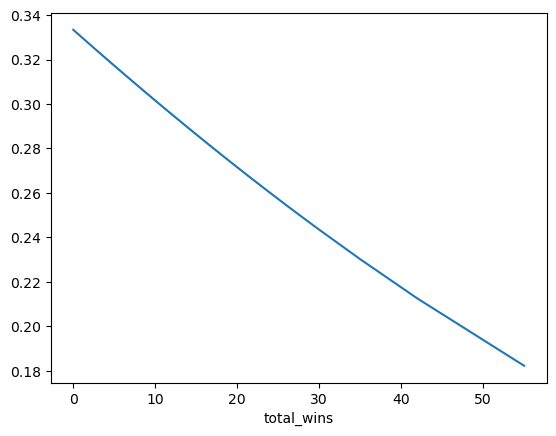

In [850]:
# Then the predicted probabilities for fighter status are plotted on the y axis and the number of wins 
# are on the x axis. This draws a better picture than 1) the first visualization of the binary variable above
# and 2) the relationsship between the variables. 

sns.lineplot(data=log_df, x="total_wins", y=wins_predict) 

From this plot I can get see the predicted probabilities when everything else is held constant. Thus, I can interpret that the lower the total wins, the higher the probability of non-active fighter status. This also mean that the higher the total wins, the higher probability that the fighter is active. I cannot claim that this supports my second hypothesis, given the non-significant relationsship, but it looks as if the trend is leaning that way. 

___ 

### Logistic regression with interaction terms

Based on the logistic regression model above, I will now include an interaction term. 

More specifically, I will look into the interaction between wins and gender: it may be that gender change how wins affects the status. In a male dominated sport, a hypothesis could be that women are invited to fight fewer times compared to men and, as a result have fewer wins which causing them to quit. It may be a stretch here, but lets investigate the effect of winning on status for a women fighter compared to when its male fighter. 


In [943]:
# estimating the model

log_status_wins_pop = smf.logit("status_binary ~ +total_wins+C(gender)*total_wins+C(gender)", data=total_df).fit()

Optimization terminated successfully.
         Current function value: 0.604496
         Iterations 5


In [944]:
# getting table
log_status_wins_pop.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [945]:
# presenting with stargazer
s_log = Stargazer([log_status_wins_pop])
s_log

Interpretation: 

   * Total wins: we can see that there is a negative relationsship between wins and status, controlling for gender. This also logically makes sense as active fighter=0 and non-active fighter=1. So for one unit increase in total wins, the status decreases: more wins, more active fighter. 
      
      
   * Gender: We see that there is a positive relationsship between gender and status, controlling for wins. This means, as women are 0 and males are 1, that for each unit increase in gender, from women to men, there is an increase in status.  This stands in opposition to my hypotheses. However, as there are fewer women in the dataset, it may simply be that the sample is not representative of reality and that fewer women in the dataset are non-active fighters compared to the men in the dataset (as there also generally are much fewer women included). 
   
* gender:wins is the relationship betwen wins and status for women and men. 
Even thought the coefficients for a logistic regression model cannot be interpreted in the same way as a linear, I will do it below to illustrate my understanding and interpretation of interaction terms. However, it should be noted that for logistic models, only the trend (positive/negative) relationsship and significance can be derived from this table. 

    Among women (=0), total wins decreases the status by -0.036. 
    
    Among men (=1), on the other hand, status is a function of the gender coefficient plus the interaction term. That is: -0.036 +0.014*1 = -0.022. The reason for this difference between the groups is only the unit increase in the gender variable. The function for women would be that same but X=0: -0.036 +0.014*0 = -0.036.
    
This means that wins has a larger effect on the status for women compared to for men; that the more wins for women, the more likely they are to be active fighter compared to more wins for men.

Ultimately, the difference in effect between women and men are the 0.014, as shown in the table at the interaction term. From this table, I can, however, also conclude that there is a statistically insignifcant effect of total wins between women and men.  

Overall, no coefficients from this analysis were significant.


In [965]:
# calculating status for relationsship between status and total wins for men
-0.036 +0.014*1

-0.022

In [966]:
# calculating status for relationsship between status and total wins for women
-0.036 +0.014*0

-0.036

In [959]:
total_df

name                nickname         weight_class  \
0          Juan Adams            "The Kraken"          Heavyweight   
1     Zarrukh Adashev              "The Lion"            Flyweight   
2       Kevin Aguilar        "Angel of Death"        Featherweight   
3         Amir Albazi            "The Prince"            Flyweight   
4           José Aldo                     NaN         Bantamweight   
..                ...                     ...                  ...   
259     Polyana Viana         "Dama de Ferro"  Women's Strawweight   
260    Rodolfo Vieira                     NaN         Middleweight   
262  Cheyanne Vlismas  "The Warrior Princess"  Women's Strawweight   
263  Alexander Volkov                 "Drago"          Heavyweight   
264     Johnny Walker                     NaN    Light Heavyweight   

                                 twitter  \
0      https://twitter.com/chosenjuan285   
1           https://twitter.com/ZAdashev   
2    https://twitter.com/KevinAguilarAOD   
3         https://twitter.com/AmirAlbazi   
4     https://twitter.com/josealdojunior   
..                                   ...   
259    https://twitter.com/Polyanavianaa   
260                                  NaN   
262  https://twitter.com/CheyWarPrincess   
263  https://twitter.com/AlexDragoVolkov   
264     https://twitter.com/JohnnyWalker   

                                      ufc_profile  gender  wins_knockout  \
0          https://www.ufc.com/athlete/juan-adams       1              5   
1     https://www.ufc.com/athlete/zarrukh-adashev       1              2   
2       https://www.ufc.com/athlete/kevin-aguilar       1              9   
3         https://www.ufc.com/athlete/amir-albazi       1              5   
4           https://www.ufc.com/athlete/jose-aldo       1             17   
..                                            ...     ...            ...   
259     https://www.ufc.com/athlete/polyana-viana       0              5   
260    https://www.ufc.com/athlete/rodolfo-vieira       1              1   
262  https://www.ufc.com/athlete/cheyanne-vlismas       0              2   
263  https://www.ufc.com/athlete/alexander-volkov       1             23   
264     https://www.ufc.com/athlete/johnny-walker       1             15   

     wins_submission  striking_accuracy sig_str_landed_min  ...  reach  \
0                  0                  0               7.09  ...     80   
1                  0                  0               3.65  ...     65   
2                  2                  0               3.96  ...     72   
3                  9                  0               3.54  ...     68   
4                  1                  0               3.57  ...     70   
..               ...                ...                ...  ...    ...   
259                8                  0               3.50  ...     67   
260                7                  0               3.62  ...     73   
262                5                  0               4.93  ...     63   
263                3                  0               4.88  ...     80   
264                2                  0               3.26  ...     82   

      twitter_handle  follower_count following_count  tweet_count  \
0      chosenjuan285          6871.0           429.0       5300.0   
1           ZAdashev           360.0            65.0         77.0   
2    KevinAguilarAOD          1306.0           509.0        949.0   
3         AmirAlbazi          3895.0           214.0        564.0   
4     josealdojunior        949482.0           146.0       7602.0   
..               ...             ...             ...          ...   
259    Polyanavianaa         29931.0            38.0        161.0   
260              nan             NaN             NaN          NaN   
262  CheyWarPrincess         12674.0           291.0       5282.0   
263  AlexDragoVolkov          8685.0            78.0        152.0   
264     JohnnyWalker         66132.0           129.0       2420.0   

                